<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ IMPORTS ✨</span>
</div>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score
import pickle
from collections import defaultdict
from sklearn.utils import shuffle
import os
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns



<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 10px 20px rgba(0,0,0,0.19), 0 6px 6px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 800; font-size: 2.5em; color: white; text-shadow: 2px 2px 4px #000;">✨ LOADING THE SPLIT DATA ARRAYS ✨</span>
</div>

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">📁 reminder to change the folder path to your numpy array folder 📁</span>
</div>

In [2]:
import numpy as np
import os

# Define the folder path
folder_path = r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\data\numpy\melnormalized\concatenatedspectrograms"

# Load the numpy files into the respective arrays with the correct capitalized naming
eeg_fold_1 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_1.npy'))
labels_fold_1 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_1.npy'))
patients_fold_1 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_1.npy'))

eeg_fold_2 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_2.npy'))
labels_fold_2 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_2.npy'))
patients_fold_2 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_2.npy'))

eeg_fold_3 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_3.npy'))
labels_fold_3 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_3.npy'))
patients_fold_3 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_3.npy'))

eeg_fold_4 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_4.npy'))
labels_fold_4 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_4.npy'))
patients_fold_4 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_4.npy'))

eeg_fold_5 = np.load(os.path.join(folder_path, 'MEL_DATA_FOLD_fold_5.npy'))
labels_fold_5 = np.load(os.path.join(folder_path, 'MEL_LABELS_FOLD_fold_5.npy'))
patients_fold_5 = np.load(os.path.join(folder_path, 'MEL_PATIENTS_FOLD_fold_5.npy'))

eeg_folds = [eeg_fold_1, eeg_fold_2, eeg_fold_3, eeg_fold_4, eeg_fold_5]
labels_folds = [labels_fold_1, labels_fold_2, labels_fold_3, labels_fold_4, labels_fold_5]
patients_folds = [patients_fold_1, patients_fold_2, patients_fold_3, patients_fold_4, patients_fold_5]

for i in range(len(eeg_folds)):
    eeg_folds[i] = eeg_folds[i].astype(np.float16)

In [3]:
eeg_fold_1.shape

(1238, 224, 224, 3)

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">data balancer & early stopping</span>
</div>

In [4]:
def data_balancer(data, labels, factor):
    # Count the number of samples in each class
    num_class_0 = np.sum(labels == 0)
    num_class_1 = np.sum(labels == 1)
    num_class_2 = np.sum(labels == 2)

    # Find the minimum number of samples across all classes
    min_samples = min(num_class_0, num_class_1, num_class_2)

    # Calculate the number of samples to take from each class
    samples_per_class = min_samples // factor

    # Randomly sample 'samples_per_class' from each class
    class_0_indices = np.random.choice(np.where(labels == 0)[0], samples_per_class, replace=False)
    class_1_indices = np.random.choice(np.where(labels == 1)[0], samples_per_class, replace=False)
    class_2_indices = np.random.choice(np.where(labels == 2)[0], samples_per_class, replace=False)

    # Combine balanced indices
    balanced_indices = np.concatenate((class_0_indices, class_1_indices, class_2_indices))

    # Shuffle the balanced indices
    np.random.shuffle(balanced_indices)

    # Create balanced training data and labels
    balanced_data = data[balanced_indices]
    balanced_labels = labels[balanced_indices]

    return balanced_data, balanced_labels

In [5]:
class EarlyStopping:
    def __init__(self, patience=5):
        """
        Initializes the early stopping mechanism based on divergence detection.

        Args:
            patience (int): Number of consecutive epochs with increasing validation loss
                            before stopping.
        """
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        """
        Checks if the validation loss is diverging and updates the state accordingly.

        Args:
            val_loss (float): Current epoch's validation loss.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss:
            # Improvement detected
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
        else:
            # Validation loss increased
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Divergence detected. Stopping training after {self.counter} epochs.")
                self.early_stop = True

    def load_best_model(self, model):
        """
        Restores the model to the state with the lowest validation loss.

        Args:
            model (torch.nn.Module): The model to restore.
        """
        model.load_state_dict(self.best_model_state)




<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(176, 238, 148),rgb(150, 232, 238)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Result plotting</span>
</div>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.preprocessing import label_binarize

def plot_metrics(labels, predictions, n_classes=3):
    """
    Plots and computes metrics for classification tasks.

    Args:
        labels (array-like): True labels.
        predictions (array-like): Predicted probabilities or class predictions.
        n_classes (int): Number of classes (default is 3 for multi-class classification).
    """
    # If predictions are probabilities, convert to class predictions
    if predictions.ndim > 1:
        predicted_classes = np.argmax(predictions, axis=1)
    else:
        predicted_classes = predictions

    # Confusion Matrix
    cm = confusion_matrix(labels, predicted_classes)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for d in range(n_classes):
        correct_preds = cm[d][d]
        total_true_samples = sum(cm[d])
        ratio_correct = correct_preds / total_true_samples if total_true_samples != 0 else 0
        print(f'Class {d}: Correct Predictions / Total True Samples = {correct_preds}/{total_true_samples} ({ratio_correct:.2%})')

    # Precision-Recall Curves and AUPRC
    print("\nPrecision-Recall Curves:")
    labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
    auprcs = []
    for class_idx in range(n_classes):
        precision, recall, _ = precision_recall_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        auprc = auc(recall, precision)
        auprcs.append(auprc)
        plt.plot(recall, precision, label=f'Class {class_idx + 1} (AUPRC = {auprc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # ROC Curves and AUC
    print("\nROC Curves:")
    for class_idx in range(n_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, class_idx], predictions[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_idx + 1} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for each class')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    # Mean F1 Score
    f1 = f1_score(labels, predicted_classes, average='macro')
    print(f"\nMean F1 Score: {f1:.4f}")

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(labels, predicted_classes)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Average AUPRC
    mean_auprc = np.mean(auprcs)
    print(f"Average AUPRC: {mean_auprc:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, predicted_classes))

    return {
        "confusion_matrix": cm,
        "class_wise_accuracy": [cm[d][d] / sum(cm[d]) if sum(cm[d]) != 0 else 0 for d in range(n_classes)],
        "mean_f1_score": f1,
        "balanced_accuracy": balanced_acc,
        "average_auprc": mean_auprc,
        "auprc_per_class": auprcs,
    }

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">MODEL GOES HERE</span>
</div>

In [7]:
debug_mode_flag = False
import torch
import torch.nn as nn

class CustomCnn(nn.Module):
    def __init__(self, debug_mode_flag=False):
        super().__init__()
        self.debug_mode_flag = debug_mode_flag
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial size
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Further reduces spatial size
        )

        # Global Average Pooling to reduce spatial dimensions 
        self.global_avg_pool = nn.AdaptiveAvgPool2d((8, 8))  # Keeps a manageable seq_len
        self.flatten = nn.Flatten(start_dim=2)  # Keeps batch & channel dims

    def forward(self, x):
        if self.debug_mode_flag: print(f"Input shape: {x.shape}")
        
        x = self.block_1(x)
        if self.debug_mode_flag: print(f"Block 1 shape: {x.shape}")
        
        x = self.block_2(x)
        if self.debug_mode_flag: print(f"Block 2 shape: {x.shape}")
        
        x = self.global_avg_pool(x)  # (batch, 128, 8, 8)
        if self.debug_mode_flag: print(f"Global Avg Pool shape: {x.shape}")

        # x = self.flatten(x)  # (batch, 128, 64)
        # if self.debug_mode_flag: print(f"Flattened shape (Transformer Input): {x.shape}")
        
        return x

    
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x):
        attn_output, _ = self.att(x, x, x)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    
class TRANS_CNN(nn.Module):
    def __init__(self, input_shape, num_classes, embed_dim=512, num_heads=2, ff_dim=64, num_transformer_blocks=4):
        
        super(TRANS_CNN,self).__init__()
        
        self.num_transformer_blocks = num_transformer_blocks
        self.cnn_extractor = CustomCnn()
        
        self.projection = nn.Linear(512, embed_dim)
        
        self.encoder = nn.ModuleList([
            TransformerEncoder(embed_dim,num_heads,ff_dim) for _ in range(num_transformer_blocks)
        ])
        
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.1)
        
        self.precls = nn.Linear(embed_dim,embed_dim)
        self.precls2 = nn.Linear(embed_dim,embed_dim)
        self.precls3 = nn.Linear(embed_dim,embed_dim//4)
        
        self.clf = nn.Linear(embed_dim//4,num_classes)
        
        
    def forward(self,x):
        
        x = self.cnn_extractor(x)
        if debug_mode_flag: print(f"x shape after cnn extraction = {x.shape}")
        
        B,C,H,W = x.shape
        
        x = x.view(B,H*W,C)
        if debug_mode_flag: print(f"x shape after changing view= {x.shape}")
        
        # x = self.projection(x)
        # if debug_mode_flag: print(f"x shape after projection= {x.shape}")
        
        for encoderblock in self.encoder:
            x = encoderblock(x)
            
        if debug_mode_flag: print(f"x shape after passing thru encoder= {x.shape}")
        
        x = x.permute(1,0,2)
        if debug_mode_flag: print(f"x shape after permuting{x.shape}")
        
        x = self.precls3(x)
        if debug_mode_flag: print(f"precls3 {x.shape}")
        
        x = self.dropout(x)
        
        x = x.mean(dim=0)  # Global average pooling over sequence (9 tokens → 1 token)
        if debug_mode_flag: print(f"x shape after average pooling {x.shape}")

        x = self.clf(x)  #they see me rolling
        if debug_mode_flag: print(f"cls {x.shape}")
        
        
        return x

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Test with demo data & model Summary</span>
</div>

In [8]:
model  = TRANS_CNN(input_shape=(224,224,3),num_classes=3,num_transformer_blocks=4,embed_dim=128) # declare model here
randomdata = torch.randn((1,3,224,224))
output = model(randomdata)
output.shape

torch.Size([1, 3])

In [9]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                                       Param #
TRANS_CNN                                                    --
├─CustomCnn: 1-1                                             --
│    └─Sequential: 2-1                                       --
│    │    └─Conv2d: 3-1                                      448
│    │    └─BatchNorm2d: 3-2                                 32
│    │    └─ReLU: 3-3                                        --
│    │    └─Conv2d: 3-4                                      4,640
│    │    └─BatchNorm2d: 3-5                                 64
│    │    └─ReLU: 3-6                                        --
│    │    └─MaxPool2d: 3-7                                   --
│    └─Sequential: 2-2                                       --
│    │    └─Conv2d: 3-8                                      18,496
│    │    └─BatchNorm2d: 3-9                                 128
│    │    └─ReLU: 3-10                                       --
│    │    └─Conv2d: 3-11  

<div style="background: linear-gradient(to right,rgb(225, 231, 134),rgb(238, 206, 148),rgb(238, 150, 150)); padding: 15px; border-radius: 8px; text-align: center; box-shadow: 0 8px 16px rgba(0,0,0,0.19), 0 4px 4px rgba(0,0,0,0.23);">
    <span style="font-family: 'Montserrat', sans-serif; font-weight: 700; font-size: 1.2em; color: white; text-shadow: 1px 1px 3px #000;">Training Code</span>
</div>

__________________________________________________
__________________________________________________
__________________________________________________
PARAMS SET 0
__________________________________________________
__________________________________________________
__________________________________________________
__________________________________________________
Fold No: 1
training on folds: [[np.int64(4), np.int64(2), np.int64(0)]]
validation on folds: 3
test on folds: 1
Epoch [1/100], Loss: 1.0995, Accuracy: 0.3465 | Validation Loss: 1.0932, Validation Accuracy: 0.3840
Epoch [2/100], Loss: 1.0869, Accuracy: 0.4240 | Validation Loss: 1.0288, Validation Accuracy: 0.4029
Epoch [3/100], Loss: 1.0662, Accuracy: 0.4868 | Validation Loss: 1.0627, Validation Accuracy: 0.4496
Epoch [4/100], Loss: 1.0300, Accuracy: 0.5512 | Validation Loss: 1.0054, Validation Accuracy: 0.4567
Epoch [5/100], Loss: 1.0029, Accuracy: 0.5965 | Validation Loss: 1.0087, Validation Accuracy: 0.4670
Epoch [6/100]

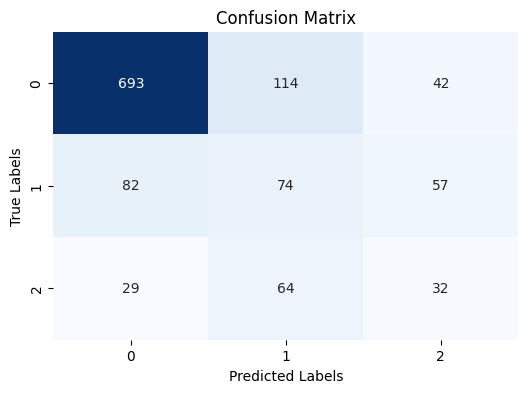


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 693/849 (81.63%)
Class 1: Correct Predictions / Total True Samples = 74/213 (34.74%)
Class 2: Correct Predictions / Total True Samples = 32/125 (25.60%)

Precision-Recall Curves:


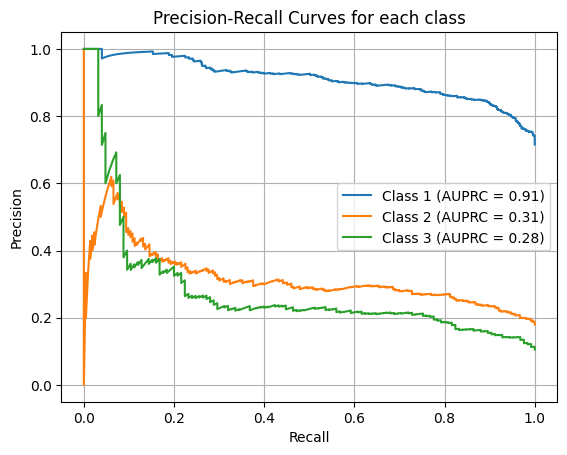


ROC Curves:


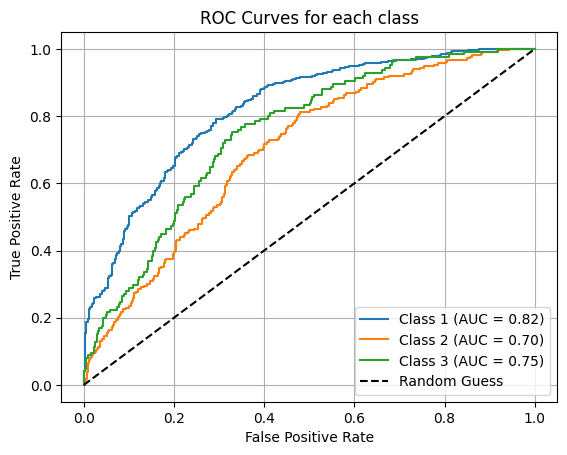


Mean F1 Score: 0.4689
Balanced Accuracy: 0.4732
Average AUPRC: 0.5010

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       849
           1       0.29      0.35      0.32       213
           2       0.24      0.26      0.25       125

    accuracy                           0.67      1187
   macro avg       0.47      0.47      0.47      1187
weighted avg       0.69      0.67      0.68      1187

__________________________________________________
Fold No: 2
training on folds: [[np.int64(2), np.int64(0), np.int64(3)]]
validation on folds: 1
test on folds: 4
Epoch [1/100], Loss: 1.1060, Accuracy: 0.3012 | Validation Loss: 1.0878, Validation Accuracy: 0.3393
Epoch [2/100], Loss: 1.0927, Accuracy: 0.4103 | Validation Loss: 1.1038, Validation Accuracy: 0.3295
Epoch [3/100], Loss: 1.0838, Accuracy: 0.4264 | Validation Loss: 1.1234, Validation Accuracy: 0.3337
Epoch [4/100], Loss: 1.0711, Accuracy: 0.4915 | Validation

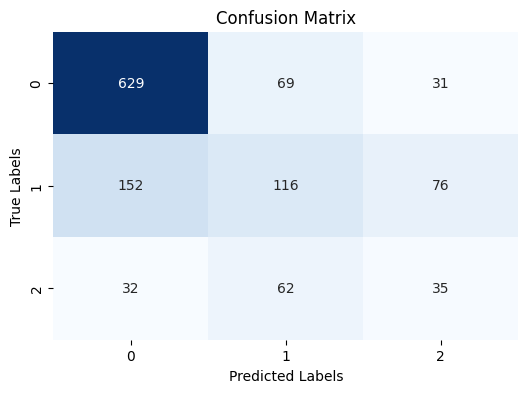


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 629/729 (86.28%)
Class 1: Correct Predictions / Total True Samples = 116/344 (33.72%)
Class 2: Correct Predictions / Total True Samples = 35/129 (27.13%)

Precision-Recall Curves:


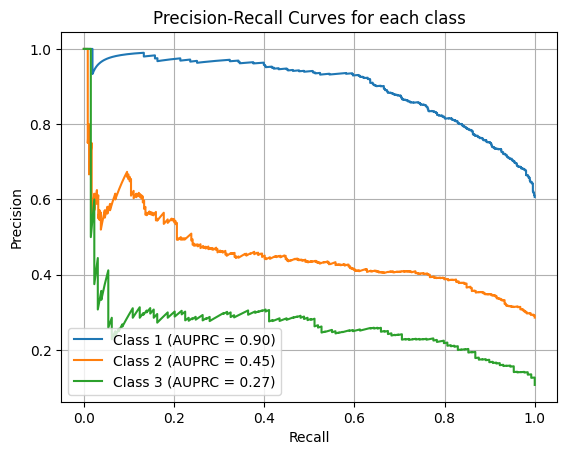


ROC Curves:


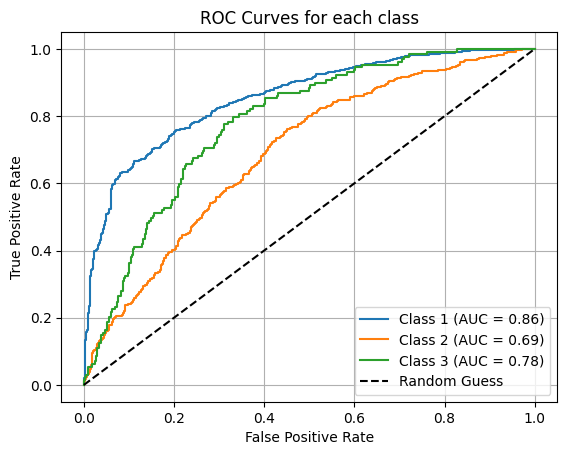


Mean F1 Score: 0.4889
Balanced Accuracy: 0.4905
Average AUPRC: 0.5408

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.82       729
           1       0.47      0.34      0.39       344
           2       0.25      0.27      0.26       129

    accuracy                           0.65      1202
   macro avg       0.50      0.49      0.49      1202
weighted avg       0.63      0.65      0.63      1202

__________________________________________________
Fold No: 3
training on folds: [[np.int64(1), np.int64(0), np.int64(3)]]
validation on folds: 4
test on folds: 2
Epoch [1/100], Loss: 1.1008, Accuracy: 0.3393 | Validation Loss: 1.1167, Validation Accuracy: 0.3442
Epoch [2/100], Loss: 1.0898, Accuracy: 0.4036 | Validation Loss: 1.0483, Validation Accuracy: 0.4201
Epoch [3/100], Loss: 1.0755, Accuracy: 0.4662 | Validation Loss: 1.0665, Validation Accuracy: 0.4222
Epoch [4/100], Loss: 1.0534, Accuracy: 0.5047 | Validation

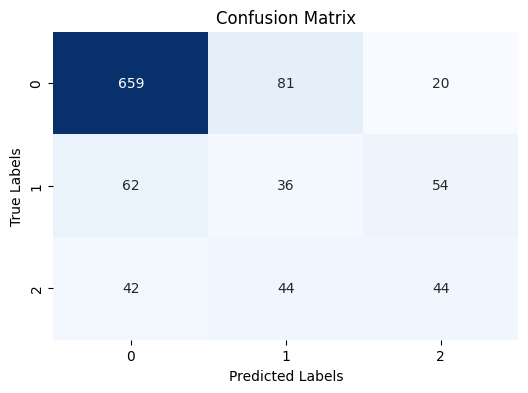


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 659/760 (86.71%)
Class 1: Correct Predictions / Total True Samples = 36/152 (23.68%)
Class 2: Correct Predictions / Total True Samples = 44/130 (33.85%)

Precision-Recall Curves:


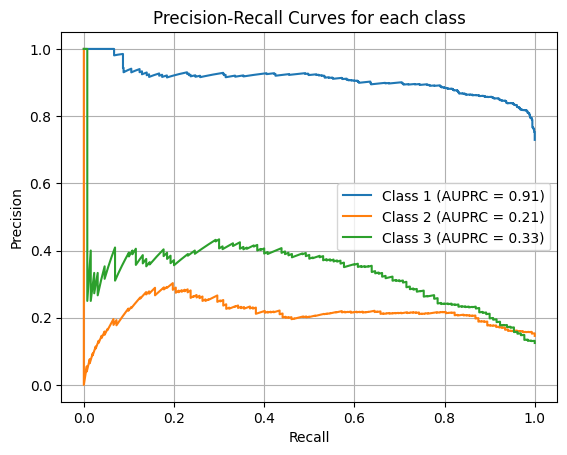


ROC Curves:


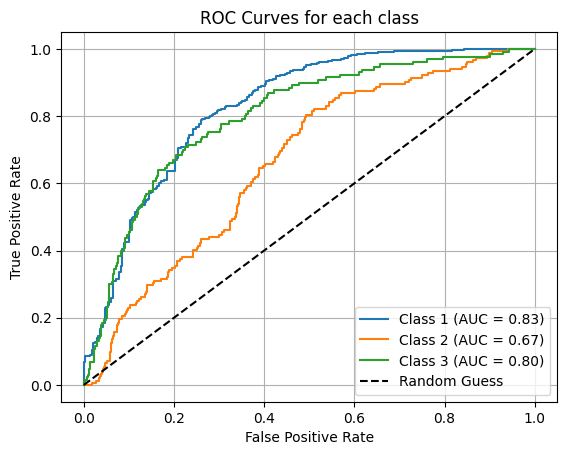


Mean F1 Score: 0.4834
Balanced Accuracy: 0.4808
Average AUPRC: 0.4854

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       760
           1       0.22      0.24      0.23       152
           2       0.37      0.34      0.35       130

    accuracy                           0.71      1042
   macro avg       0.49      0.48      0.48      1042
weighted avg       0.71      0.71      0.71      1042

__________________________________________________
Fold No: 4
training on folds: [[np.int64(1), np.int64(4), np.int64(3)]]
validation on folds: 2
test on folds: 0
Epoch [1/100], Loss: 1.0949, Accuracy: 0.3707 | Validation Loss: 1.0897, Validation Accuracy: 0.3854
Epoch [2/100], Loss: 1.0899, Accuracy: 0.4019 | Validation Loss: 1.1173, Validation Accuracy: 0.4243
Epoch [3/100], Loss: 1.0808, Accuracy: 0.4081 | Validation Loss: 1.1031, Validation Accuracy: 0.4171
Epoch [4/100], Loss: 1.0766, Accuracy: 0.4289 | Validation

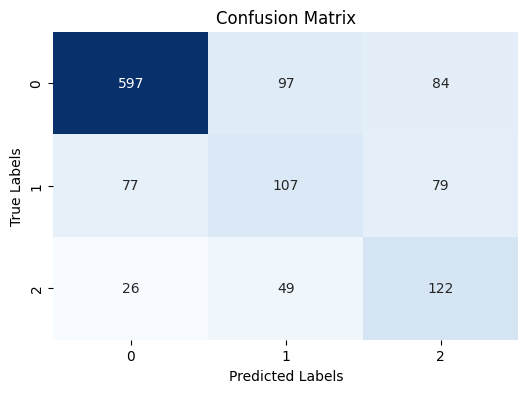


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 597/778 (76.74%)
Class 1: Correct Predictions / Total True Samples = 107/263 (40.68%)
Class 2: Correct Predictions / Total True Samples = 122/197 (61.93%)

Precision-Recall Curves:


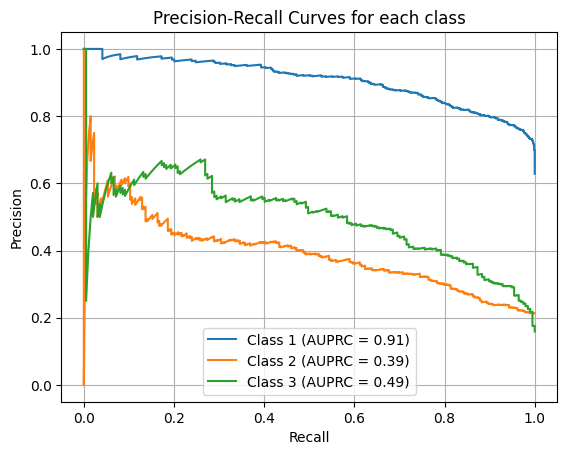


ROC Curves:


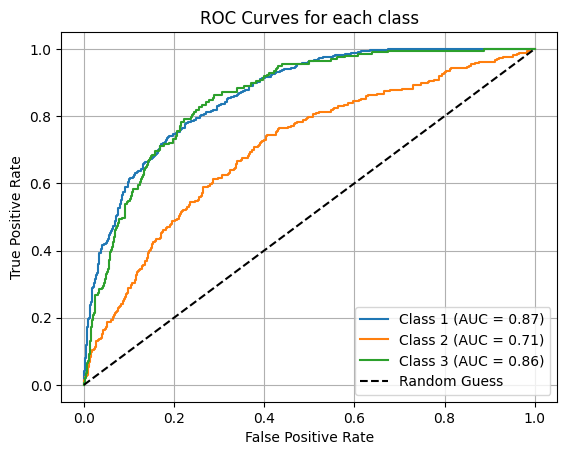


Mean F1 Score: 0.5763
Balanced Accuracy: 0.5978
Average AUPRC: 0.5974

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81       778
           1       0.42      0.41      0.41       263
           2       0.43      0.62      0.51       197

    accuracy                           0.67      1238
   macro avg       0.57      0.60      0.58      1238
weighted avg       0.69      0.67      0.68      1238

__________________________________________________
Fold No: 5
training on folds: [[np.int64(1), np.int64(4), np.int64(2)]]
validation on folds: 0
test on folds: 3
Epoch [1/100], Loss: 1.0954, Accuracy: 0.3628 | Validation Loss: 1.1012, Validation Accuracy: 0.3927
Epoch [2/100], Loss: 1.0799, Accuracy: 0.4444 | Validation Loss: 1.0812, Validation Accuracy: 0.4717
Epoch [3/100], Loss: 1.0651, Accuracy: 0.4800 | Validation Loss: 1.0649, Validation Accuracy: 0.4947
Epoch [4/100], Loss: 1.0492, Accuracy: 0.5069 | Validation

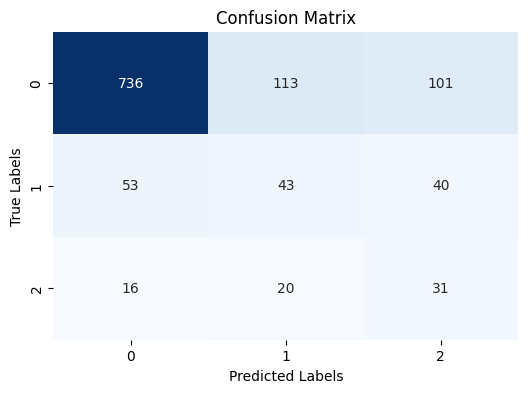


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 736/950 (77.47%)
Class 1: Correct Predictions / Total True Samples = 43/136 (31.62%)
Class 2: Correct Predictions / Total True Samples = 31/67 (46.27%)

Precision-Recall Curves:


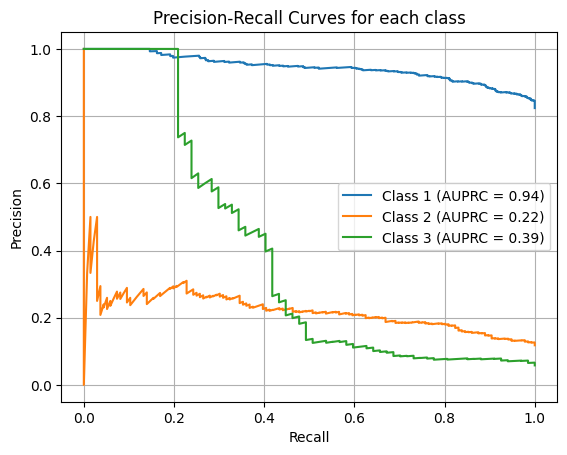


ROC Curves:


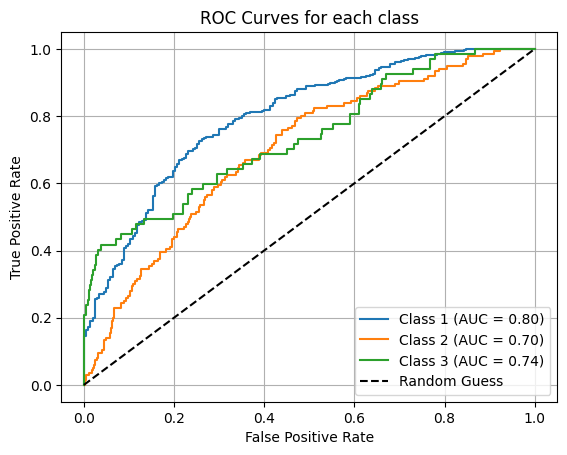


Mean F1 Score: 0.4579
Balanced Accuracy: 0.5179
Average AUPRC: 0.5169

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.77      0.84       950
           1       0.24      0.32      0.28       136
           2       0.18      0.46      0.26        67

    accuracy                           0.70      1153
   macro avg       0.45      0.52      0.46      1153
weighted avg       0.79      0.70      0.74      1153

Accuracy for each fold: [np.float64(0.4732240857789059), np.float64(0.4904509735115535), np.float64(0.4808029689608637), np.float64(0.5978285438851252), np.float64(0.5178666266192259)]
AUPRC for each fold: [np.float64(0.5009610026316645), np.float64(0.5407524433016254), np.float64(0.4853831748122106), np.float64(0.5974014285185963), np.float64(0.516855890019463)]
Average AUPRC across all folds: 0.528270787856712
Average Balanced Accuracy across all folds: 0.5120346397511348
Results saved to D:\PYTHONIG\newwindow\NOTEBO

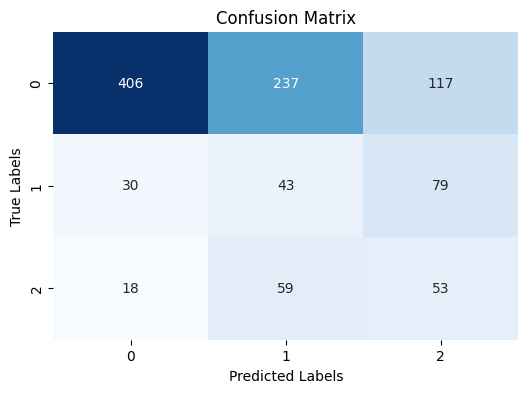


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 406/760 (53.42%)
Class 1: Correct Predictions / Total True Samples = 43/152 (28.29%)
Class 2: Correct Predictions / Total True Samples = 53/130 (40.77%)

Precision-Recall Curves:


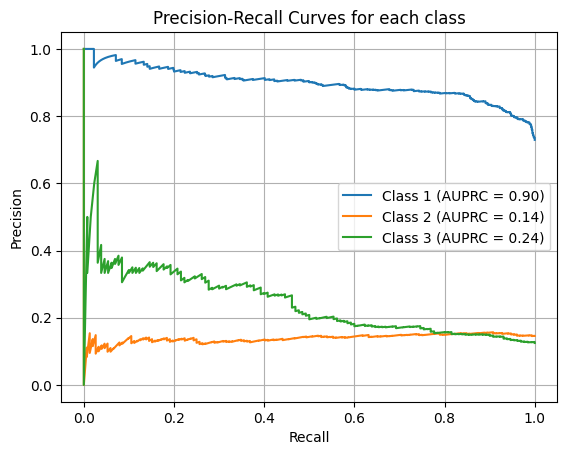


ROC Curves:


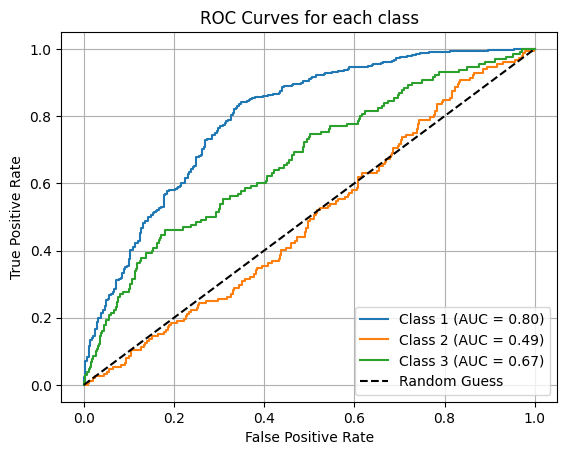


Mean F1 Score: 0.3746
Balanced Accuracy: 0.4083
Average AUPRC: 0.4256

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.53      0.67       760
           1       0.13      0.28      0.18       152
           2       0.21      0.41      0.28       130

    accuracy                           0.48      1042
   macro avg       0.41      0.41      0.37      1042
weighted avg       0.70      0.48      0.55      1042

__________________________________________________
Fold No: 2
training on folds: [[np.int64(4), np.int64(0), np.int64(3)]]
validation on folds: 2
test on folds: 1
Epoch [1/100], Loss: 1.1057, Accuracy: 0.3494 | Validation Loss: 1.0858, Validation Accuracy: 0.3268
Epoch [2/100], Loss: 1.0993, Accuracy: 0.3164 | Validation Loss: 1.1097, Validation Accuracy: 0.3422
Epoch [3/100], Loss: 1.0974, Accuracy: 0.3868 | Validation Loss: 1.1225, Validation Accuracy: 0.3658
Epoch [4/100], Loss: 1.0956, Accuracy: 0.3647 | Validation

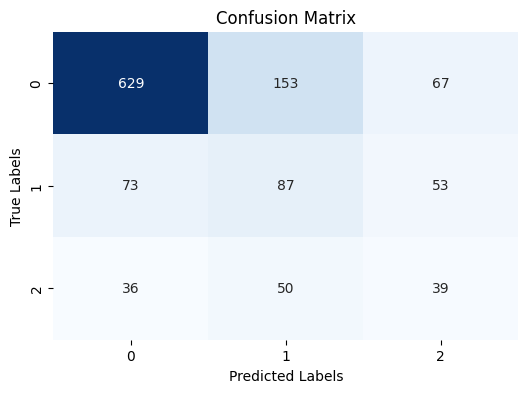


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 629/849 (74.09%)
Class 1: Correct Predictions / Total True Samples = 87/213 (40.85%)
Class 2: Correct Predictions / Total True Samples = 39/125 (31.20%)

Precision-Recall Curves:


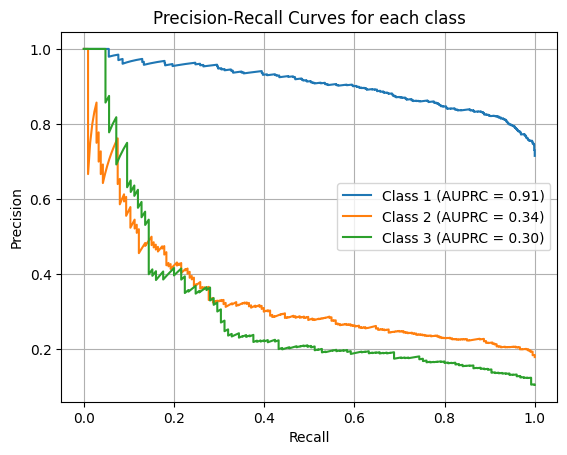


ROC Curves:


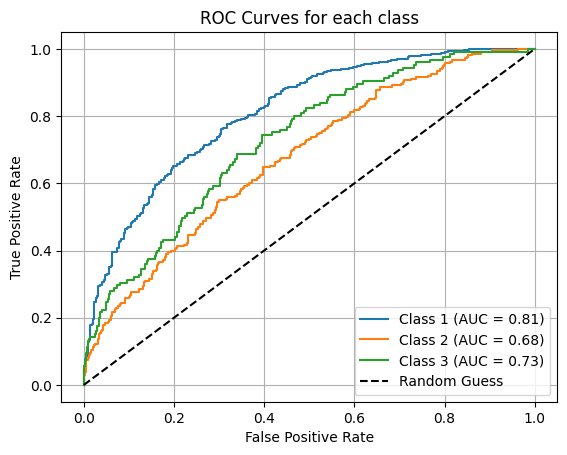


Mean F1 Score: 0.4711
Balanced Accuracy: 0.4871
Average AUPRC: 0.5156

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       849
           1       0.30      0.41      0.35       213
           2       0.25      0.31      0.27       125

    accuracy                           0.64      1187
   macro avg       0.47      0.49      0.47      1187
weighted avg       0.69      0.64      0.66      1187

__________________________________________________
Fold No: 3
training on folds: [[np.int64(2), np.int64(0), np.int64(3)]]
validation on folds: 1
test on folds: 4
Epoch [1/100], Loss: 1.1014, Accuracy: 0.3723 | Validation Loss: 1.0921, Validation Accuracy: 0.3498
Epoch [2/100], Loss: 1.0950, Accuracy: 0.3621 | Validation Loss: 1.1147, Validation Accuracy: 0.3489
Epoch [3/100], Loss: 1.0911, Accuracy: 0.3951 | Validation Loss: 1.1138, Validation Accuracy: 0.3614
Epoch [4/100], Loss: 1.0852, Accuracy: 0.4543 | Validation

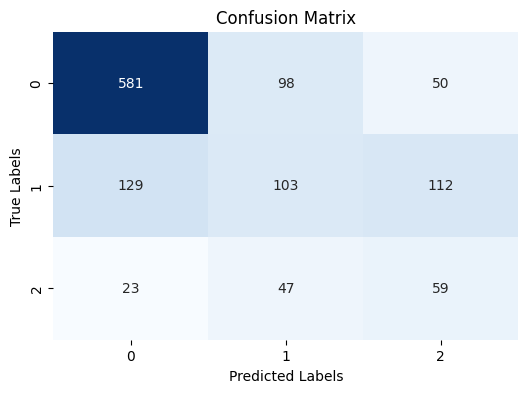


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 581/729 (79.70%)
Class 1: Correct Predictions / Total True Samples = 103/344 (29.94%)
Class 2: Correct Predictions / Total True Samples = 59/129 (45.74%)

Precision-Recall Curves:


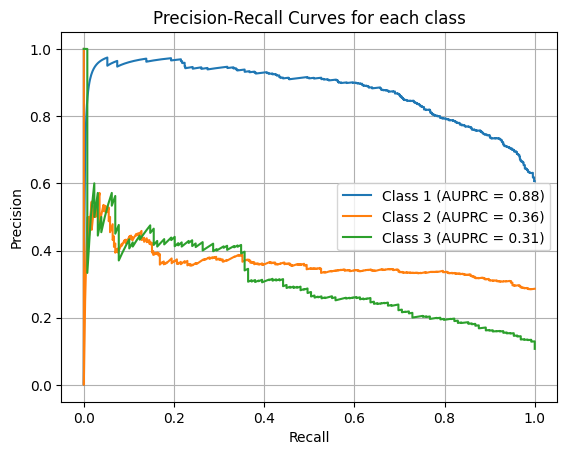


ROC Curves:


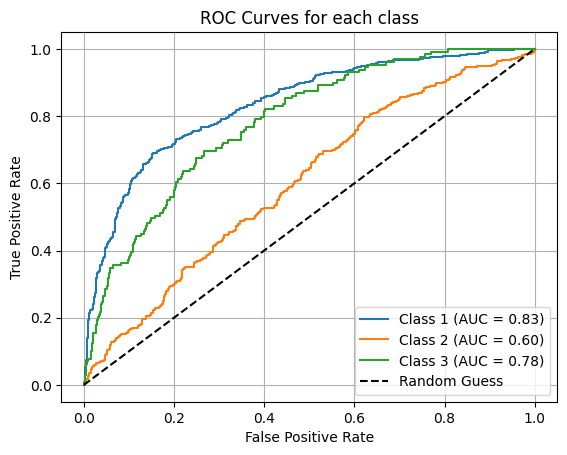


Mean F1 Score: 0.4933
Balanced Accuracy: 0.5179
Average AUPRC: 0.5152

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       729
           1       0.42      0.30      0.35       344
           2       0.27      0.46      0.34       129

    accuracy                           0.62      1202
   macro avg       0.49      0.52      0.49      1202
weighted avg       0.63      0.62      0.62      1202

__________________________________________________
Fold No: 4
training on folds: [[np.int64(2), np.int64(1), np.int64(3)]]
validation on folds: 4
test on folds: 0
Epoch [1/100], Loss: 1.0992, Accuracy: 0.3437 | Validation Loss: 1.0790, Validation Accuracy: 0.3291
Epoch [2/100], Loss: 1.0974, Accuracy: 0.3571 | Validation Loss: 1.0849, Validation Accuracy: 0.3600
Epoch [3/100], Loss: 1.0962, Accuracy: 0.3954 | Validation Loss: 1.0943, Validation Accuracy: 0.3659
Epoch [4/100], Loss: 1.0968, Accuracy: 0.3768 | Validation

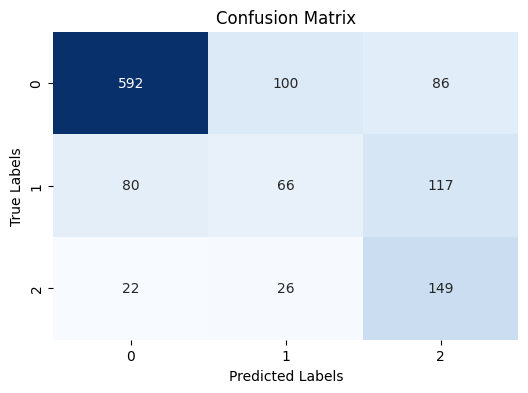


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 592/778 (76.09%)
Class 1: Correct Predictions / Total True Samples = 66/263 (25.10%)
Class 2: Correct Predictions / Total True Samples = 149/197 (75.63%)

Precision-Recall Curves:


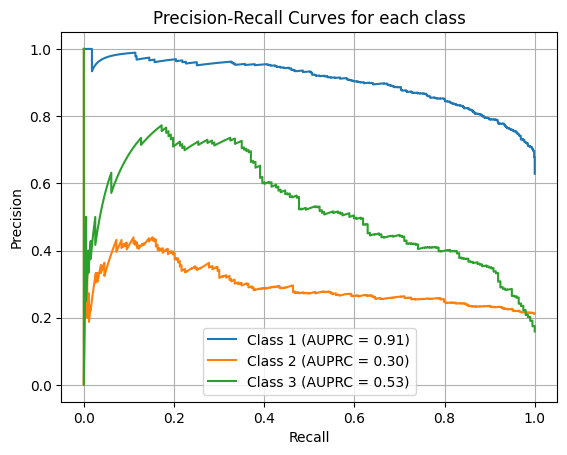


ROC Curves:


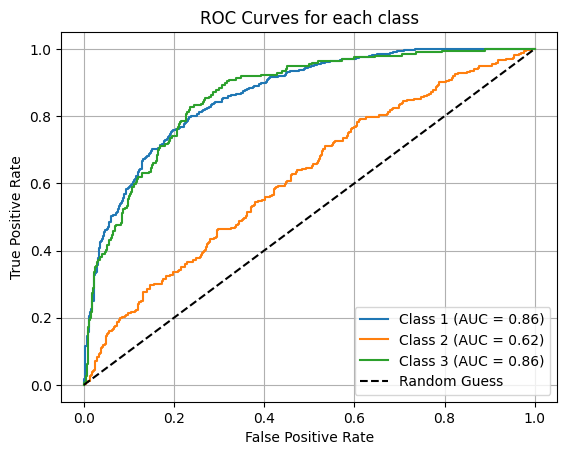


Mean F1 Score: 0.5458
Balanced Accuracy: 0.5894
Average AUPRC: 0.5764

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       778
           1       0.34      0.25      0.29       263
           2       0.42      0.76      0.54       197

    accuracy                           0.65      1238
   macro avg       0.54      0.59      0.55      1238
weighted avg       0.68      0.65      0.65      1238

__________________________________________________
Fold No: 5
training on folds: [[np.int64(2), np.int64(1), np.int64(4)]]
validation on folds: 0
test on folds: 3
Epoch [1/100], Loss: 1.1063, Accuracy: 0.3411 | Validation Loss: 1.1212, Validation Accuracy: 0.3339
Epoch [2/100], Loss: 1.1015, Accuracy: 0.3238 | Validation Loss: 1.0996, Validation Accuracy: 0.2995
Epoch [3/100], Loss: 1.0985, Accuracy: 0.3576 | Validation Loss: 1.1007, Validation Accuracy: 0.3330
Epoch [4/100], Loss: 1.0983, Accuracy: 0.3429 | Validation

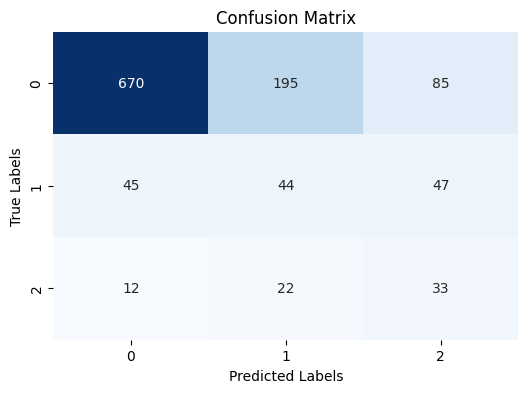


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 670/950 (70.53%)
Class 1: Correct Predictions / Total True Samples = 44/136 (32.35%)
Class 2: Correct Predictions / Total True Samples = 33/67 (49.25%)

Precision-Recall Curves:


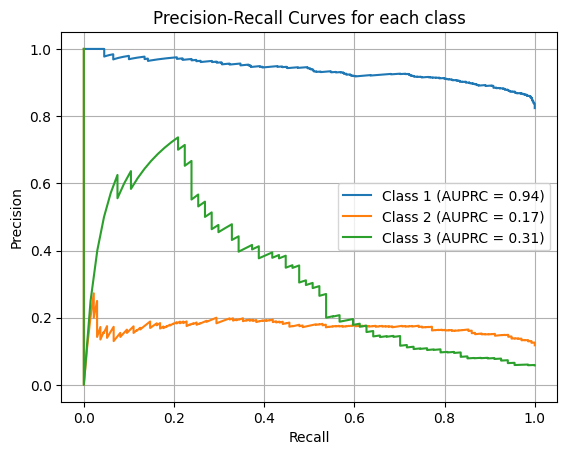


ROC Curves:


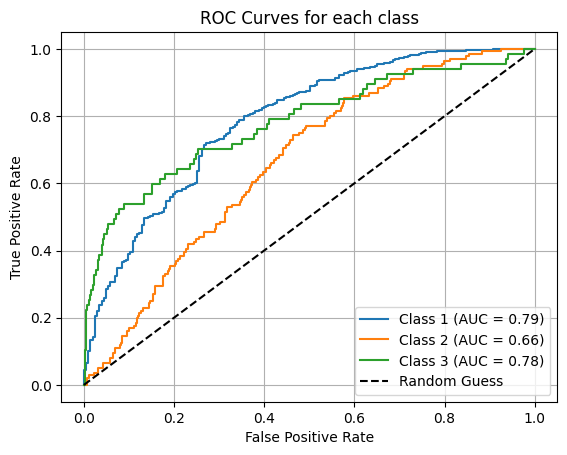


Mean F1 Score: 0.4351
Balanced Accuracy: 0.5071
Average AUPRC: 0.4738

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       950
           1       0.17      0.32      0.22       136
           2       0.20      0.49      0.28        67

    accuracy                           0.65      1153
   macro avg       0.43      0.51      0.44      1153
weighted avg       0.79      0.65      0.70      1153

Accuracy for each fold: [np.float64(0.40826585695006745), np.float64(0.4871074392961618), np.float64(0.5179217043629906), np.float64(0.5894070659595484), np.float64(0.5071099610307596)]
AUPRC for each fold: [np.float64(0.42562011576809883), np.float64(0.5155781093065284), np.float64(0.5152092939421835), np.float64(0.5764104775204864), np.float64(0.47375424504907754)]
Average AUPRC across all folds: 0.5013144483172749
Average Balanced Accuracy across all folds: 0.5019624055199057
Results saved to D:\PYTHONIG\newwindow\N

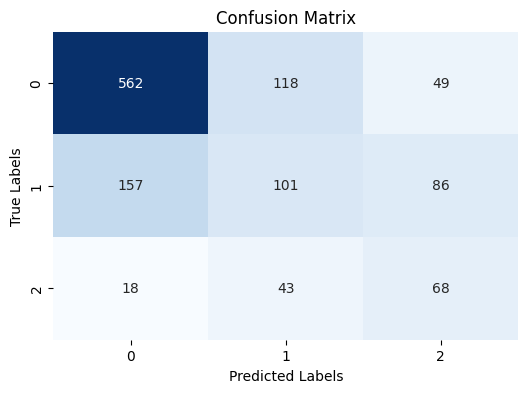


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 562/729 (77.09%)
Class 1: Correct Predictions / Total True Samples = 101/344 (29.36%)
Class 2: Correct Predictions / Total True Samples = 68/129 (52.71%)

Precision-Recall Curves:


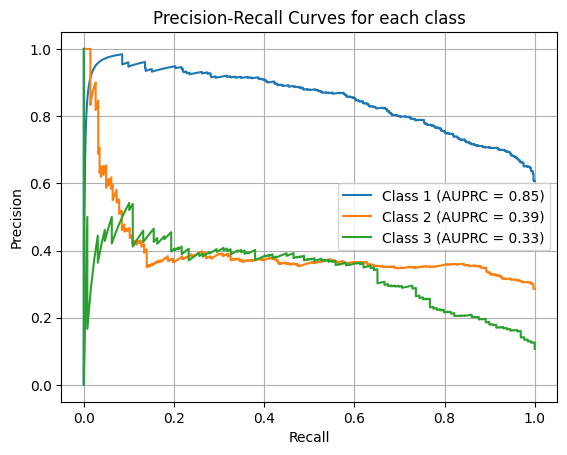


ROC Curves:


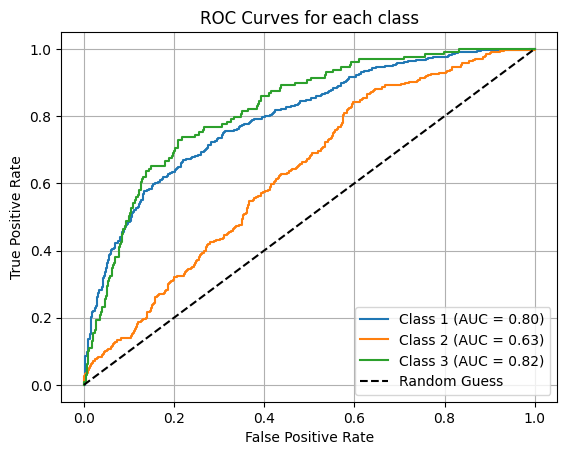


Mean F1 Score: 0.5032
Balanced Accuracy: 0.5306
Average AUPRC: 0.5259

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77       729
           1       0.39      0.29      0.33       344
           2       0.33      0.53      0.41       129

    accuracy                           0.61      1202
   macro avg       0.49      0.53      0.50      1202
weighted avg       0.61      0.61      0.60      1202

__________________________________________________
Fold No: 2
training on folds: [[np.int64(2), np.int64(1), np.int64(0)]]
validation on folds: 4
test on folds: 3
Epoch [1/100], Loss: 1.1007, Accuracy: 0.3481 | Validation Loss: 1.0919, Validation Accuracy: 0.3388
Epoch [2/100], Loss: 1.0973, Accuracy: 0.3577 | Validation Loss: 1.0963, Validation Accuracy: 0.3529
Epoch [3/100], Loss: 1.0937, Accuracy: 0.3820 | Validation Loss: 1.0882, Validation Accuracy: 0.3707
Epoch [4/100], Loss: 1.0923, Accuracy: 0.3886 | Validation

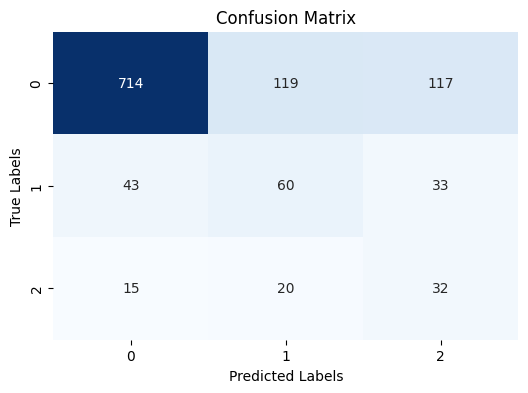


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 714/950 (75.16%)
Class 1: Correct Predictions / Total True Samples = 60/136 (44.12%)
Class 2: Correct Predictions / Total True Samples = 32/67 (47.76%)

Precision-Recall Curves:


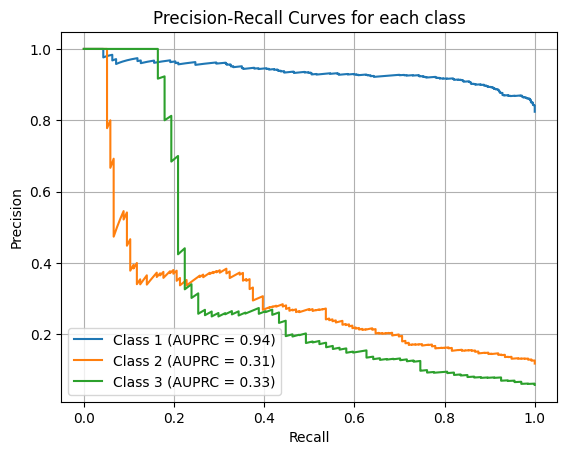


ROC Curves:


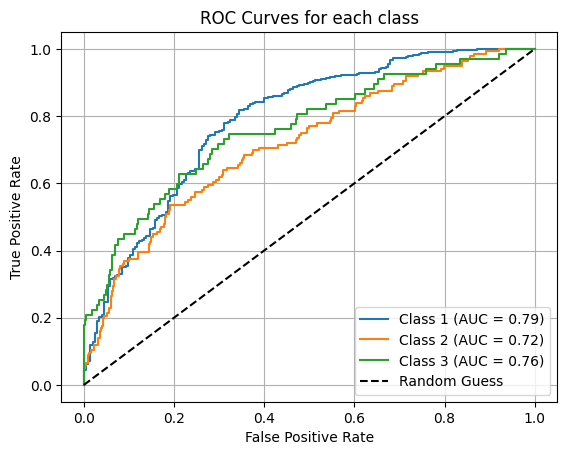


Mean F1 Score: 0.4815
Balanced Accuracy: 0.5568
Average AUPRC: 0.5247

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.75      0.83       950
           1       0.30      0.44      0.36       136
           2       0.18      0.48      0.26        67

    accuracy                           0.70      1153
   macro avg       0.47      0.56      0.48      1153
weighted avg       0.81      0.70      0.74      1153

__________________________________________________
Fold No: 3
training on folds: [[np.int64(4), np.int64(1), np.int64(0)]]
validation on folds: 3
test on folds: 2
Epoch [1/100], Loss: 1.1094, Accuracy: 0.3186 | Validation Loss: 1.0853, Validation Accuracy: 0.2943
Epoch [2/100], Loss: 1.0990, Accuracy: 0.3585 | Validation Loss: 1.0815, Validation Accuracy: 0.3410
Epoch [3/100], Loss: 1.0954, Accuracy: 0.3762 | Validation Loss: 1.0921, Validation Accuracy: 0.3972
Epoch [4/100], Loss: 1.0924, Accuracy: 0.3799 | Validation

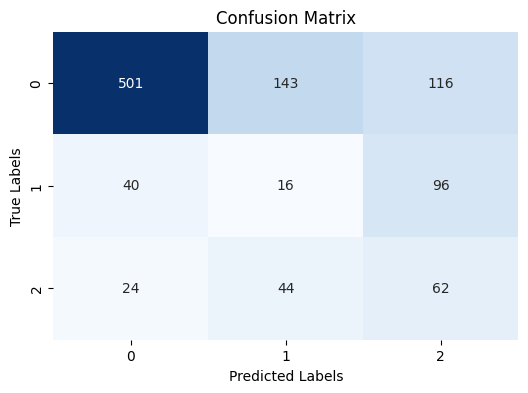


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 501/760 (65.92%)
Class 1: Correct Predictions / Total True Samples = 16/152 (10.53%)
Class 2: Correct Predictions / Total True Samples = 62/130 (47.69%)

Precision-Recall Curves:


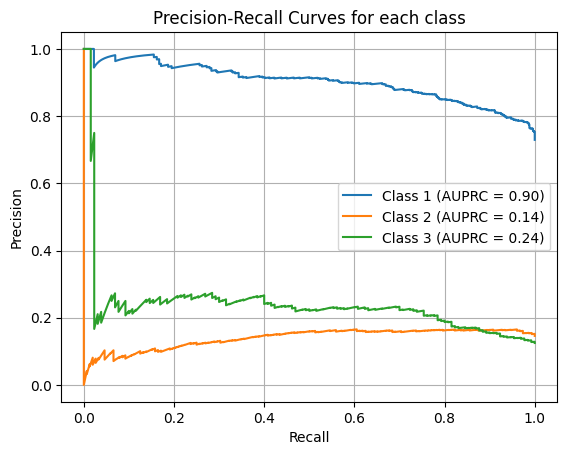


ROC Curves:


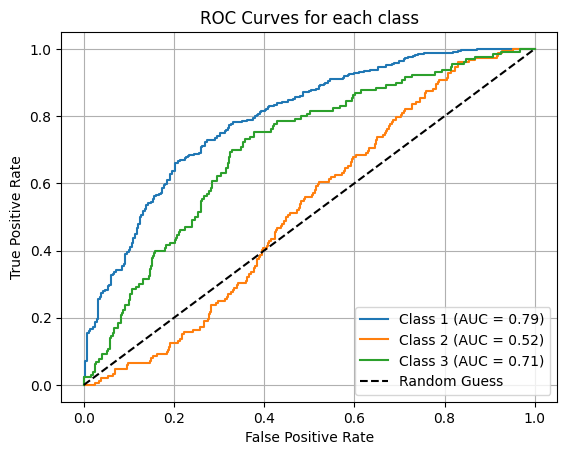


Mean F1 Score: 0.3844
Balanced Accuracy: 0.4138
Average AUPRC: 0.4256

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       760
           1       0.08      0.11      0.09       152
           2       0.23      0.48      0.31       130

    accuracy                           0.56      1042
   macro avg       0.40      0.41      0.38      1042
weighted avg       0.69      0.56      0.60      1042

__________________________________________________
Fold No: 4
training on folds: [[np.int64(4), np.int64(3), np.int64(0)]]
validation on folds: 2
test on folds: 1
Epoch [1/100], Loss: 1.1022, Accuracy: 0.3215 | Validation Loss: 1.0873, Validation Accuracy: 0.3468
Epoch [2/100], Loss: 1.0968, Accuracy: 0.3656 | Validation Loss: 1.0841, Validation Accuracy: 0.3526
Epoch [3/100], Loss: 1.0922, Accuracy: 0.3766 | Validation Loss: 1.1018, Validation Accuracy: 0.3068
Epoch [4/100], Loss: 1.0900, Accuracy: 0.3936 | Validation

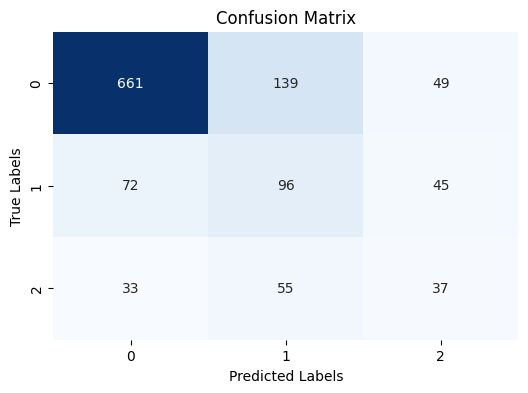


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 661/849 (77.86%)
Class 1: Correct Predictions / Total True Samples = 96/213 (45.07%)
Class 2: Correct Predictions / Total True Samples = 37/125 (29.60%)

Precision-Recall Curves:


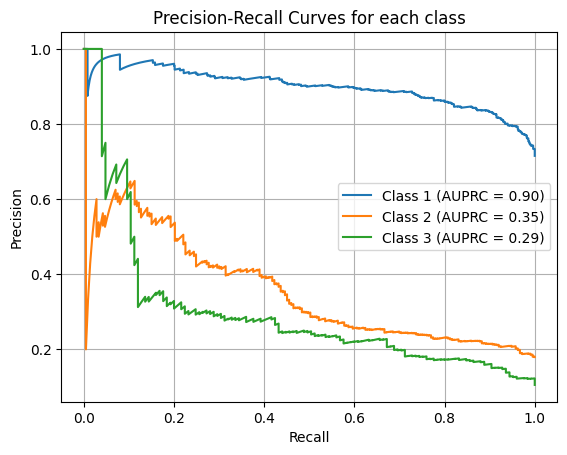


ROC Curves:


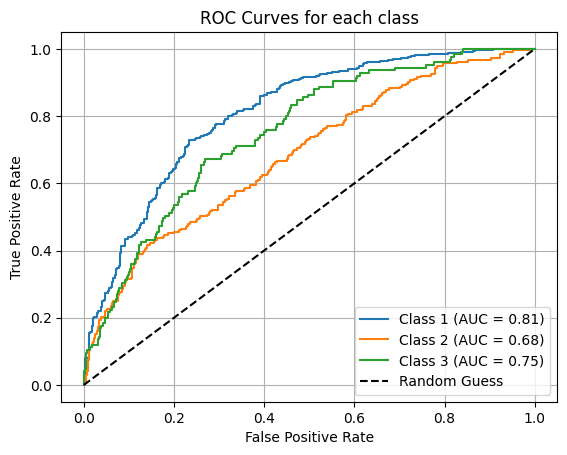


Mean F1 Score: 0.4964
Balanced Accuracy: 0.5084
Average AUPRC: 0.5153

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       849
           1       0.33      0.45      0.38       213
           2       0.28      0.30      0.29       125

    accuracy                           0.67      1187
   macro avg       0.49      0.51      0.50      1187
weighted avg       0.71      0.67      0.68      1187

__________________________________________________
Fold No: 5
training on folds: [[np.int64(4), np.int64(3), np.int64(2)]]
validation on folds: 1
test on folds: 0
Epoch [1/100], Loss: 1.0997, Accuracy: 0.3344 | Validation Loss: 1.0454, Validation Accuracy: 0.3333
Epoch [2/100], Loss: 1.0995, Accuracy: 0.3589 | Validation Loss: 1.1166, Validation Accuracy: 0.3299
Epoch [3/100], Loss: 1.0932, Accuracy: 0.3804 | Validation Loss: 1.1135, Validation Accuracy: 0.3762
Epoch [4/100], Loss: 1.0908, Accuracy: 0.3885 | Validation

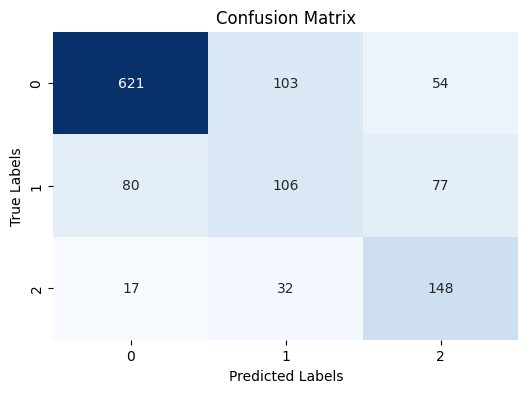


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 621/778 (79.82%)
Class 1: Correct Predictions / Total True Samples = 106/263 (40.30%)
Class 2: Correct Predictions / Total True Samples = 148/197 (75.13%)

Precision-Recall Curves:


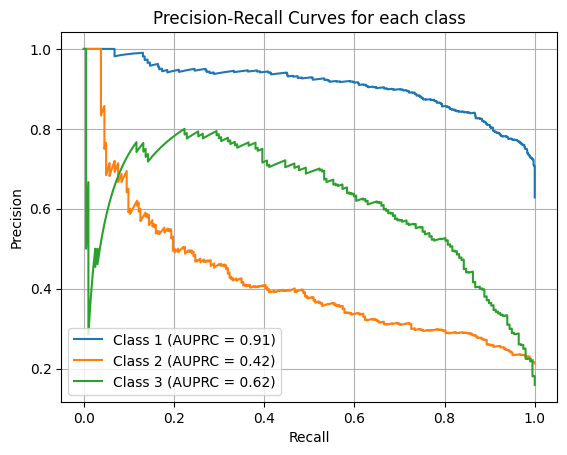


ROC Curves:


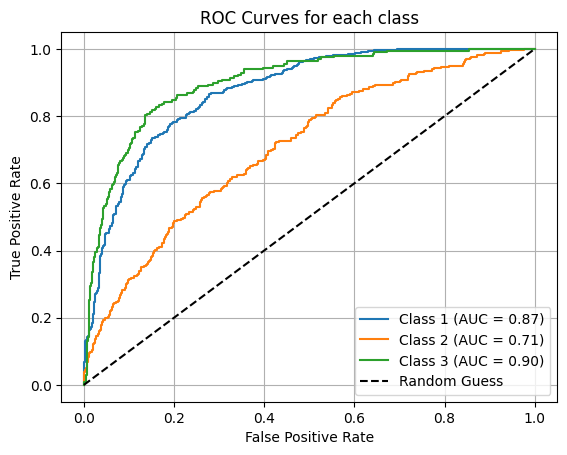


Mean F1 Score: 0.6242
Balanced Accuracy: 0.6508
Average AUPRC: 0.6486

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       778
           1       0.44      0.40      0.42       263
           2       0.53      0.75      0.62       197

    accuracy                           0.71      1238
   macro avg       0.61      0.65      0.62      1238
weighted avg       0.72      0.71      0.71      1238

Accuracy for each fold: [np.float64(0.5305518337746302), np.float64(0.5567891194183879), np.float64(0.41379892037786775), np.float64(0.5084224135547483), np.float64(0.6508371249222898)]
AUPRC for each fold: [np.float64(0.5258551873520544), np.float64(0.5246894149430862), np.float64(0.4255598032404873), np.float64(0.5152631885339701), np.float64(0.6486116965111555)]
Average AUPRC across all folds: 0.5279958581161507
Average Balanced Accuracy across all folds: 0.5320798824095848
Results saved to D:\PYTHONIG\newwindow\NOT

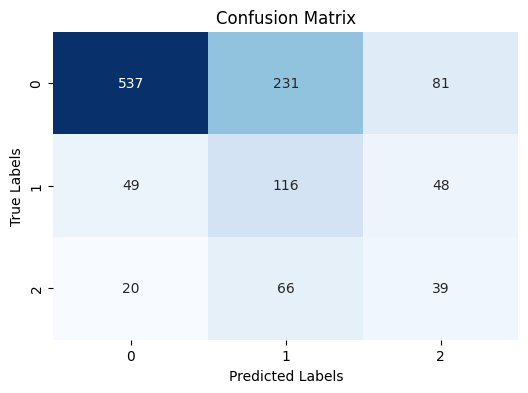


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 537/849 (63.25%)
Class 1: Correct Predictions / Total True Samples = 116/213 (54.46%)
Class 2: Correct Predictions / Total True Samples = 39/125 (31.20%)

Precision-Recall Curves:


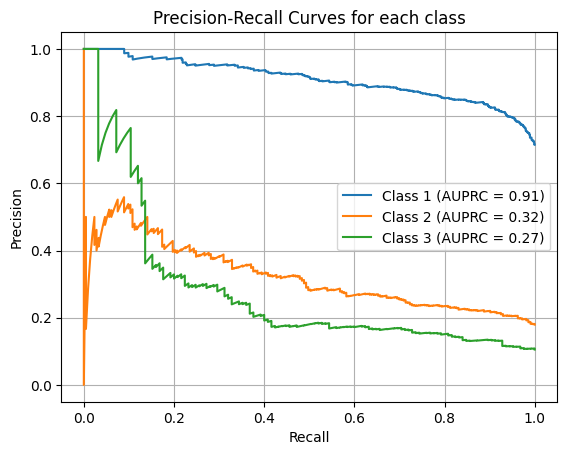


ROC Curves:


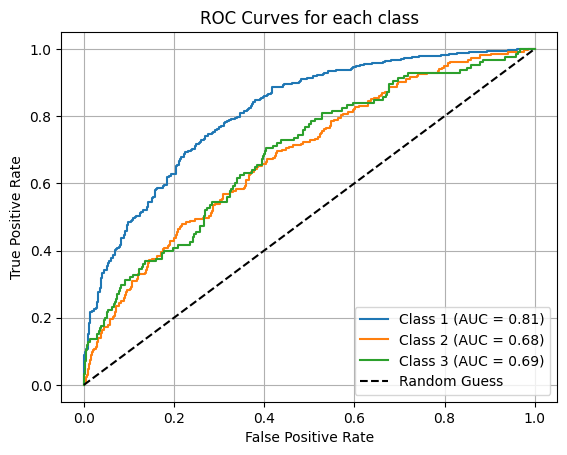


Mean F1 Score: 0.4583
Balanced Accuracy: 0.4964
Average AUPRC: 0.5014

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.63      0.74       849
           1       0.28      0.54      0.37       213
           2       0.23      0.31      0.27       125

    accuracy                           0.58      1187
   macro avg       0.47      0.50      0.46      1187
weighted avg       0.71      0.58      0.62      1187

__________________________________________________
Fold No: 2
training on folds: [[np.int64(0), np.int64(4), np.int64(2)]]
validation on folds: 1
test on folds: 3
Epoch [1/100], Loss: 1.0862, Accuracy: 0.3955 | Validation Loss: 0.9709, Validation Accuracy: 0.3973
Epoch [2/100], Loss: 1.0361, Accuracy: 0.5132 | Validation Loss: 0.9445, Validation Accuracy: 0.4784
Epoch [3/100], Loss: 0.9841, Accuracy: 0.5994 | Validation Loss: 1.0422, Validation Accuracy: 0.4764
Epoch [4/100], Loss: 0.9540, Accuracy: 0.6447 | Validation

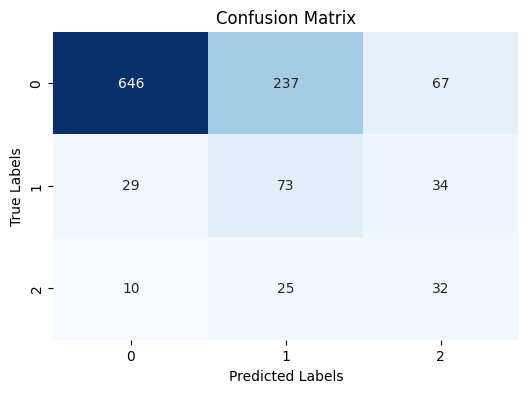


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 646/950 (68.00%)
Class 1: Correct Predictions / Total True Samples = 73/136 (53.68%)
Class 2: Correct Predictions / Total True Samples = 32/67 (47.76%)

Precision-Recall Curves:


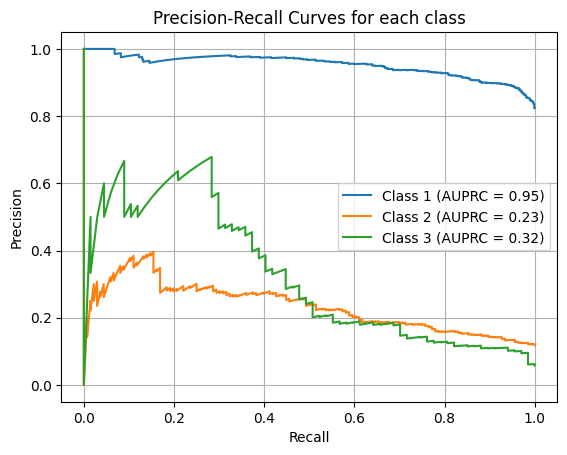


ROC Curves:


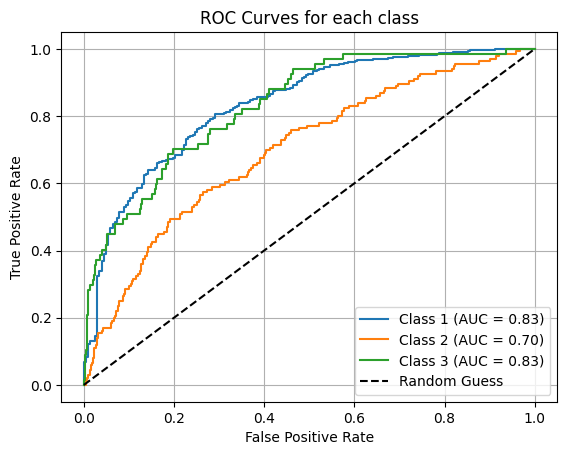


Mean F1 Score: 0.4734
Balanced Accuracy: 0.5648
Average AUPRC: 0.5005

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.68      0.79       950
           1       0.22      0.54      0.31       136
           2       0.24      0.48      0.32        67

    accuracy                           0.65      1153
   macro avg       0.47      0.56      0.47      1153
weighted avg       0.82      0.65      0.71      1153

__________________________________________________
Fold No: 3
training on folds: [[np.int64(1), np.int64(4), np.int64(2)]]
validation on folds: 3
test on folds: 0
Epoch [1/100], Loss: 1.0920, Accuracy: 0.3932 | Validation Loss: 0.9690, Validation Accuracy: 0.3741
Epoch [2/100], Loss: 1.0576, Accuracy: 0.4835 | Validation Loss: 1.1013, Validation Accuracy: 0.4260
Epoch [3/100], Loss: 1.0146, Accuracy: 0.5686 | Validation Loss: 1.0743, Validation Accuracy: 0.4451
Epoch [4/100], Loss: 0.9853, Accuracy: 0.5981 | Validation

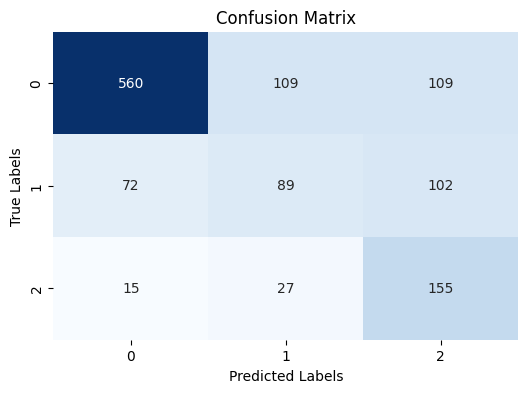


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 560/778 (71.98%)
Class 1: Correct Predictions / Total True Samples = 89/263 (33.84%)
Class 2: Correct Predictions / Total True Samples = 155/197 (78.68%)

Precision-Recall Curves:


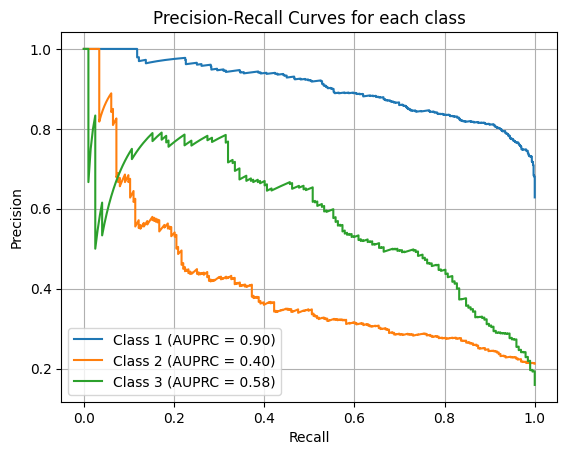


ROC Curves:


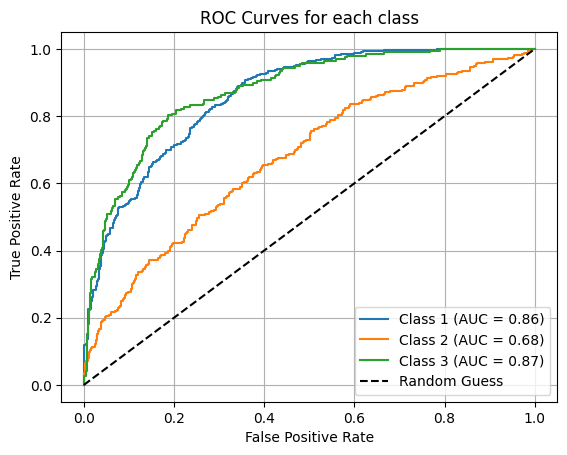


Mean F1 Score: 0.5671
Balanced Accuracy: 0.6150
Average AUPRC: 0.6283

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       778
           1       0.40      0.34      0.36       263
           2       0.42      0.79      0.55       197

    accuracy                           0.65      1238
   macro avg       0.56      0.61      0.57      1238
weighted avg       0.70      0.65      0.66      1238

__________________________________________________
Fold No: 4
training on folds: [[np.int64(1), np.int64(3), np.int64(2)]]
validation on folds: 0
test on folds: 4
Epoch [1/100], Loss: 1.0890, Accuracy: 0.4099 | Validation Loss: 1.1175, Validation Accuracy: 0.4219
Epoch [2/100], Loss: 1.0603, Accuracy: 0.4886 | Validation Loss: 1.0025, Validation Accuracy: 0.5143
Epoch [3/100], Loss: 1.0380, Accuracy: 0.5393 | Validation Loss: 1.0354, Validation Accuracy: 0.5317
Epoch [4/100], Loss: 1.0048, Accuracy: 0.5859 | Validation

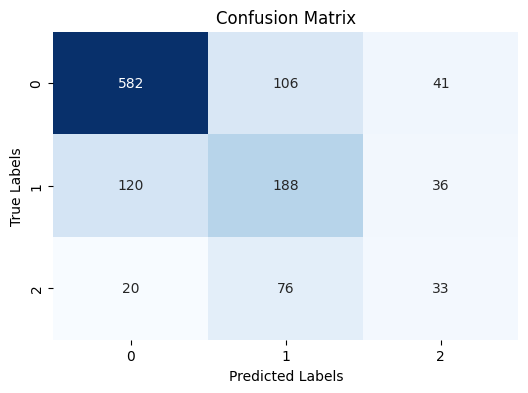


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 582/729 (79.84%)
Class 1: Correct Predictions / Total True Samples = 188/344 (54.65%)
Class 2: Correct Predictions / Total True Samples = 33/129 (25.58%)

Precision-Recall Curves:


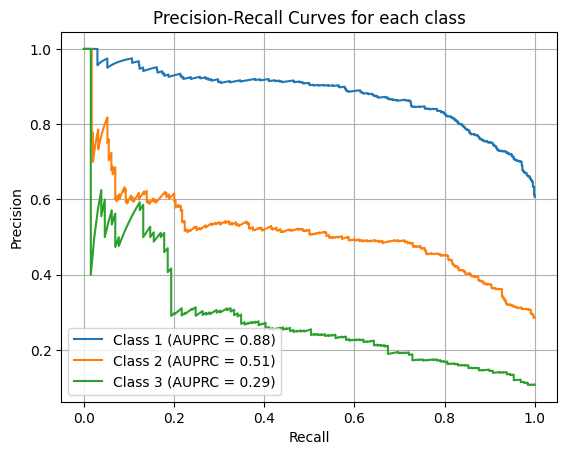


ROC Curves:


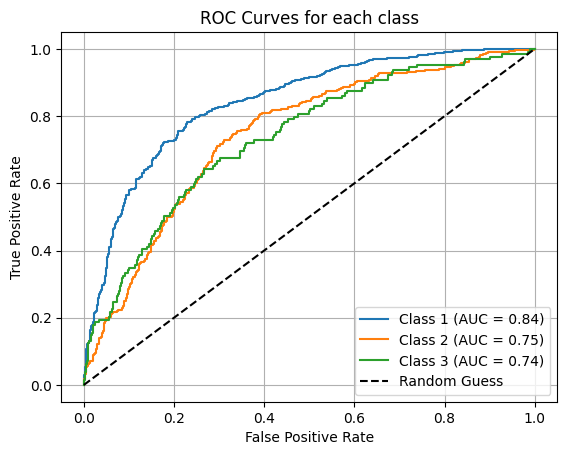


Mean F1 Score: 0.5350
Balanced Accuracy: 0.5336
Average AUPRC: 0.5595

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       729
           1       0.51      0.55      0.53       344
           2       0.30      0.26      0.28       129

    accuracy                           0.67      1202
   macro avg       0.54      0.53      0.53      1202
weighted avg       0.67      0.67      0.67      1202

__________________________________________________
Fold No: 5
training on folds: [[np.int64(1), np.int64(3), np.int64(0)]]
validation on folds: 4
test on folds: 2
Epoch [1/100], Loss: 1.0776, Accuracy: 0.4396 | Validation Loss: 1.0321, Validation Accuracy: 0.5122
Epoch [2/100], Loss: 1.0236, Accuracy: 0.5236 | Validation Loss: 0.9683, Validation Accuracy: 0.5372
Epoch [3/100], Loss: 0.9939, Accuracy: 0.5775 | Validation Loss: 0.9837, Validation Accuracy: 0.5661
Epoch [4/100], Loss: 0.9701, Accuracy: 0.6195 | Validation

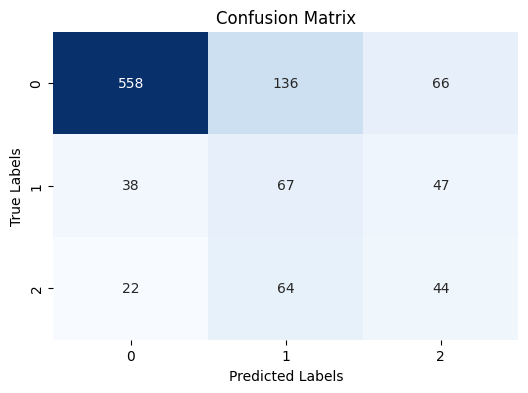


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 558/760 (73.42%)
Class 1: Correct Predictions / Total True Samples = 67/152 (44.08%)
Class 2: Correct Predictions / Total True Samples = 44/130 (33.85%)

Precision-Recall Curves:


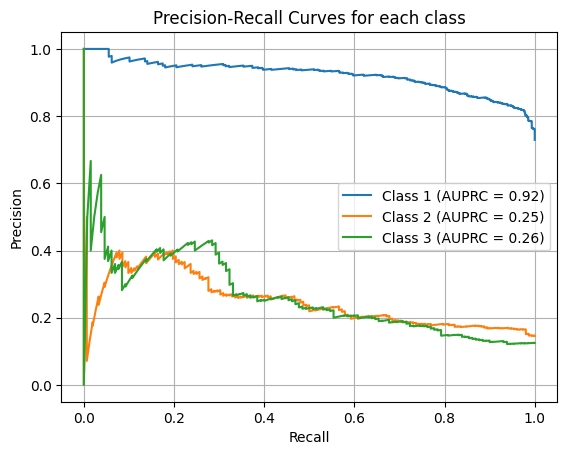


ROC Curves:


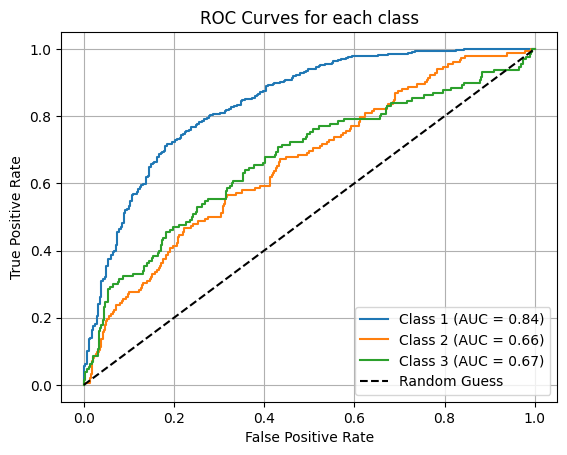


Mean F1 Score: 0.4788
Balanced Accuracy: 0.5045
Average AUPRC: 0.4753

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81       760
           1       0.25      0.44      0.32       152
           2       0.28      0.34      0.31       130

    accuracy                           0.64      1042
   macro avg       0.48      0.50      0.48      1042
weighted avg       0.73      0.64      0.68      1042

Accuracy for each fold: [np.float64(0.49636992429646587), np.float64(0.5647922153936201), np.float64(0.6149998055849851), np.float64(0.5335598302867898), np.float64(0.5044871794871795)]
AUPRC for each fold: [np.float64(0.501394577705388), np.float64(0.5004949596865959), np.float64(0.6283387943877674), np.float64(0.5595301604345368), np.float64(0.47530175108956785)]
Average AUPRC across all folds: 0.5330120486607712
Average Balanced Accuracy across all folds: 0.5428417910098081
Results saved to D:\PYTHONIG\newwindow\NOT

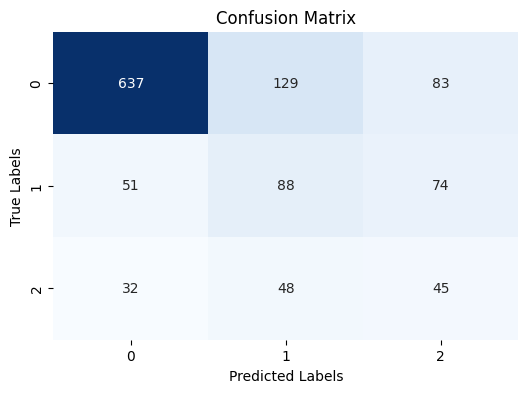


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 637/849 (75.03%)
Class 1: Correct Predictions / Total True Samples = 88/213 (41.31%)
Class 2: Correct Predictions / Total True Samples = 45/125 (36.00%)

Precision-Recall Curves:


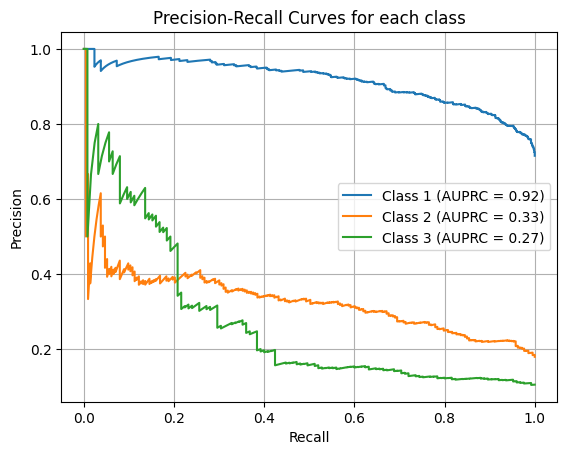


ROC Curves:


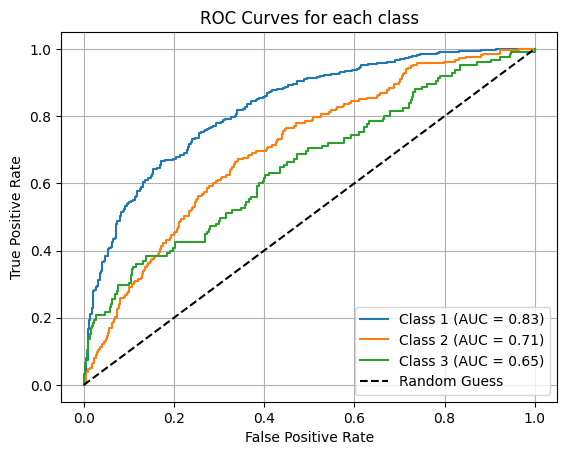


Mean F1 Score: 0.4851
Balanced Accuracy: 0.5078
Average AUPRC: 0.5032

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       849
           1       0.33      0.41      0.37       213
           2       0.22      0.36      0.28       125

    accuracy                           0.65      1187
   macro avg       0.48      0.51      0.49      1187
weighted avg       0.72      0.65      0.68      1187

__________________________________________________
Fold No: 2
training on folds: [[np.int64(0), np.int64(3), np.int64(4)]]
validation on folds: 1
test on folds: 2
Epoch [1/100], Loss: 1.1008, Accuracy: 0.3350 | Validation Loss: 1.1193, Validation Accuracy: 0.3193
Epoch [2/100], Loss: 1.0902, Accuracy: 0.4012 | Validation Loss: 1.1300, Validation Accuracy: 0.3399
Epoch [3/100], Loss: 1.0766, Accuracy: 0.4673 | Validation Loss: 1.0683, Validation Accuracy: 0.3962
Epoch [4/100], Loss: 1.0540, Accuracy: 0.4792 | Validation

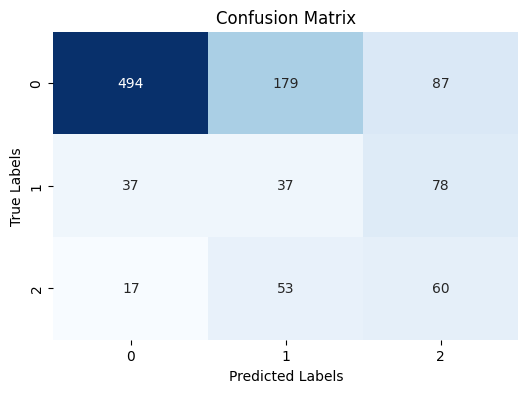


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 494/760 (65.00%)
Class 1: Correct Predictions / Total True Samples = 37/152 (24.34%)
Class 2: Correct Predictions / Total True Samples = 60/130 (46.15%)

Precision-Recall Curves:


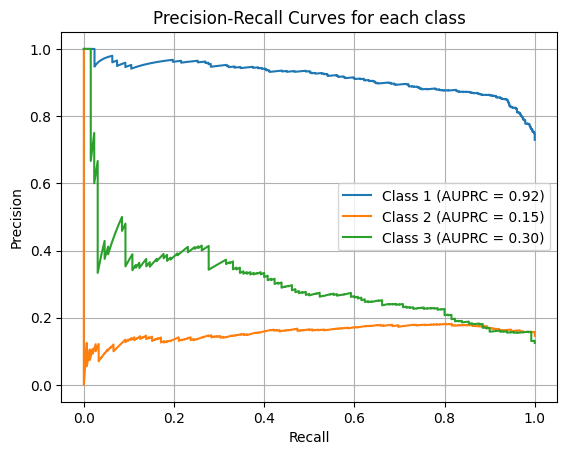


ROC Curves:


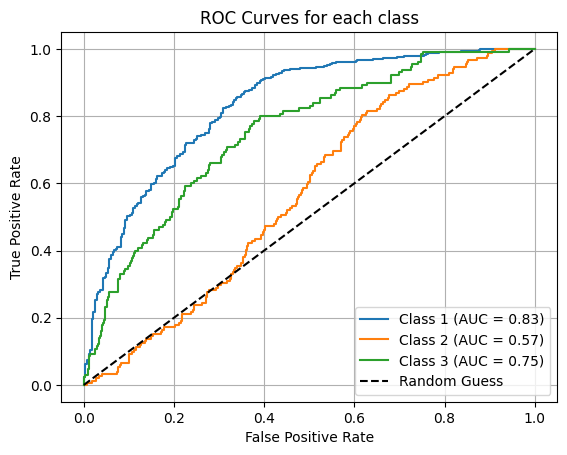


Mean F1 Score: 0.4231
Balanced Accuracy: 0.4517
Average AUPRC: 0.4584

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.65      0.76       760
           1       0.14      0.24      0.18       152
           2       0.27      0.46      0.34       130

    accuracy                           0.57      1042
   macro avg       0.44      0.45      0.42      1042
weighted avg       0.71      0.57      0.62      1042

__________________________________________________
Fold No: 3
training on folds: [[np.int64(1), np.int64(3), np.int64(4)]]
validation on folds: 2
test on folds: 0
Epoch [1/100], Loss: 1.1027, Accuracy: 0.3115 | Validation Loss: 1.0943, Validation Accuracy: 0.3294
Epoch [2/100], Loss: 1.0985, Accuracy: 0.3572 | Validation Loss: 1.1292, Validation Accuracy: 0.3329
Epoch [3/100], Loss: 1.0932, Accuracy: 0.3801 | Validation Loss: 1.0900, Validation Accuracy: 0.3656
Epoch [4/100], Loss: 1.0948, Accuracy: 0.4008 | Validation

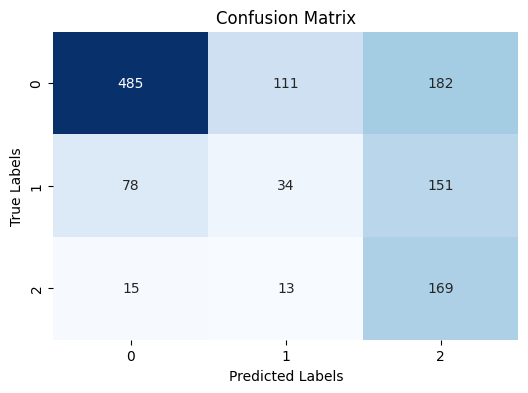


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 485/778 (62.34%)
Class 1: Correct Predictions / Total True Samples = 34/263 (12.93%)
Class 2: Correct Predictions / Total True Samples = 169/197 (85.79%)

Precision-Recall Curves:


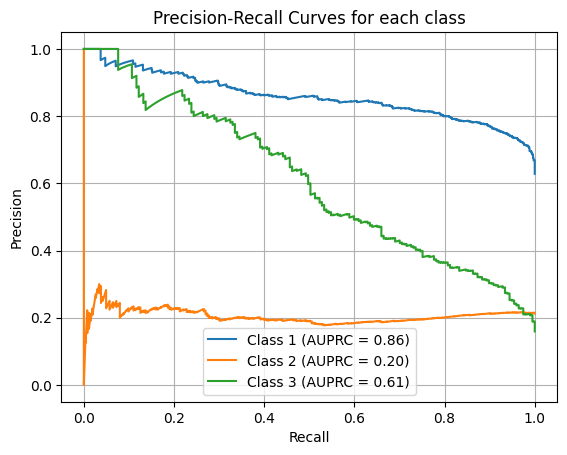


ROC Curves:


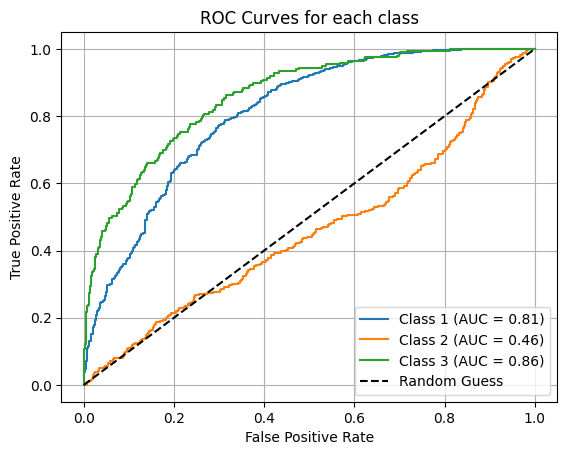


Mean F1 Score: 0.4535
Balanced Accuracy: 0.5368
Average AUPRC: 0.5563

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.62      0.72       778
           1       0.22      0.13      0.16       263
           2       0.34      0.86      0.48       197

    accuracy                           0.56      1238
   macro avg       0.46      0.54      0.45      1238
weighted avg       0.63      0.56      0.56      1238

__________________________________________________
Fold No: 4
training on folds: [[np.int64(1), np.int64(2), np.int64(4)]]
validation on folds: 0
test on folds: 3
Epoch [1/100], Loss: 1.1046, Accuracy: 0.3220 | Validation Loss: 1.0824, Validation Accuracy: 0.3702
Epoch [2/100], Loss: 1.0950, Accuracy: 0.3767 | Validation Loss: 1.1096, Validation Accuracy: 0.3995
Epoch [3/100], Loss: 1.0929, Accuracy: 0.3915 | Validation Loss: 1.0841, Validation Accuracy: 0.4381
Epoch [4/100], Loss: 1.0862, Accuracy: 0.4028 | Validation

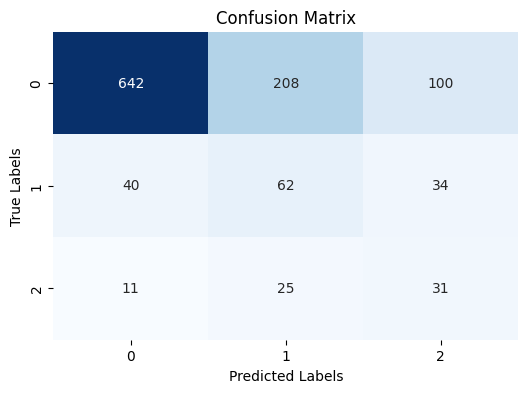


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 642/950 (67.58%)
Class 1: Correct Predictions / Total True Samples = 62/136 (45.59%)
Class 2: Correct Predictions / Total True Samples = 31/67 (46.27%)

Precision-Recall Curves:


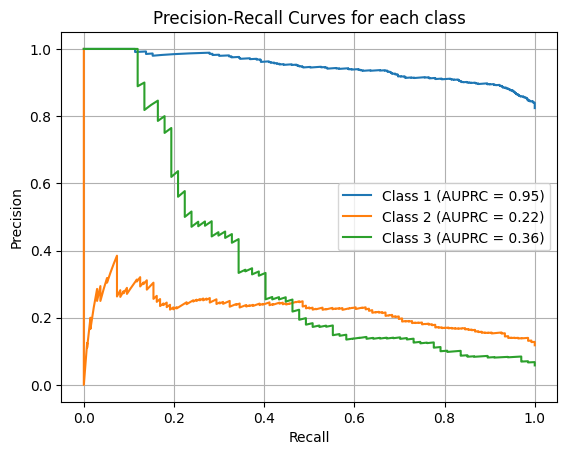


ROC Curves:


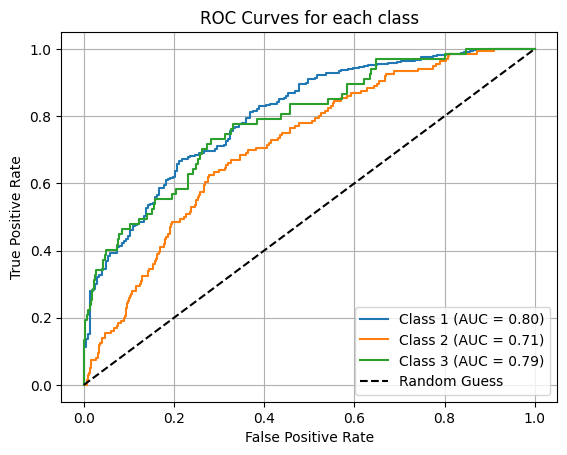


Mean F1 Score: 0.4455
Balanced Accuracy: 0.5315
Average AUPRC: 0.5075

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.68      0.78       950
           1       0.21      0.46      0.29       136
           2       0.19      0.46      0.27        67

    accuracy                           0.64      1153
   macro avg       0.44      0.53      0.45      1153
weighted avg       0.80      0.64      0.69      1153

__________________________________________________
Fold No: 5
training on folds: [[np.int64(1), np.int64(2), np.int64(0)]]
validation on folds: 3
test on folds: 4
Epoch [1/100], Loss: 1.1086, Accuracy: 0.3392 | Validation Loss: 1.0951, Validation Accuracy: 0.2820
Epoch [2/100], Loss: 1.0983, Accuracy: 0.3481 | Validation Loss: 1.1246, Validation Accuracy: 0.3337
Epoch [3/100], Loss: 1.0967, Accuracy: 0.3473 | Validation Loss: 1.1348, Validation Accuracy: 0.3333
Epoch [4/100], Loss: 1.0959, Accuracy: 0.3982 | Validation

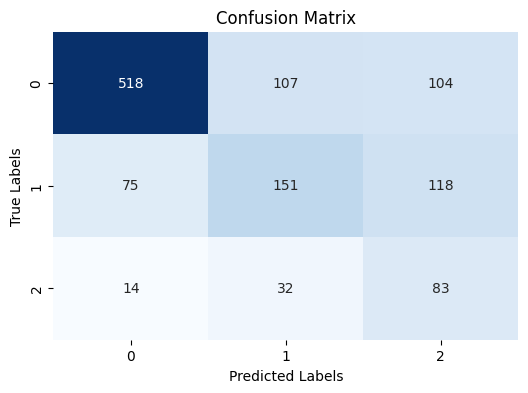


Class-wise Accuracy:
Class 0: Correct Predictions / Total True Samples = 518/729 (71.06%)
Class 1: Correct Predictions / Total True Samples = 151/344 (43.90%)
Class 2: Correct Predictions / Total True Samples = 83/129 (64.34%)

Precision-Recall Curves:


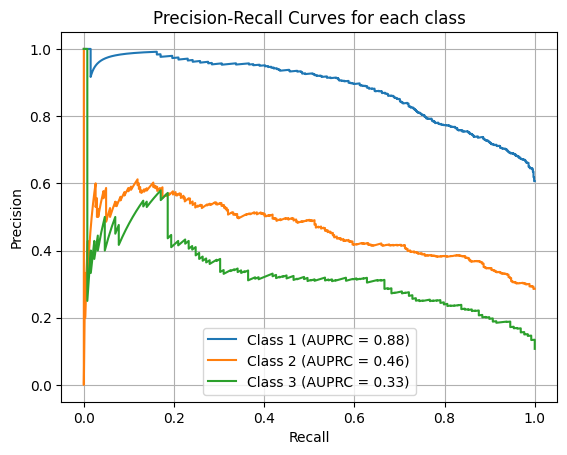


ROC Curves:


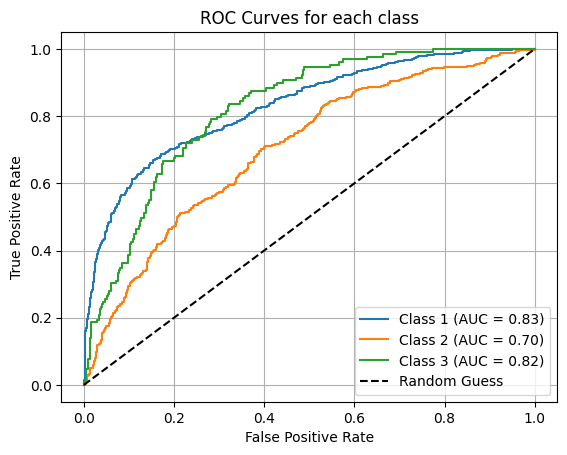


Mean F1 Score: 0.5448
Balanced Accuracy: 0.5976
Average AUPRC: 0.5586

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.78       729
           1       0.52      0.44      0.48       344
           2       0.27      0.64      0.38       129

    accuracy                           0.63      1202
   macro avg       0.55      0.60      0.54      1202
weighted avg       0.70      0.63      0.65      1202

Accuracy for each fold: [np.float64(0.5078133346604954), np.float64(0.45165317139001354), np.float64(0.5368463010132883), np.float64(0.5314527979298553), np.float64(0.5976422517837964)]
AUPRC for each fold: [np.float64(0.5031573482812329), np.float64(0.4583505114254753), np.float64(0.5563418465843477), np.float64(0.5074832022181798), np.float64(0.5585603705263454)]
Average AUPRC across all folds: 0.5167786558071162
Average Balanced Accuracy across all folds: 0.5250815713554898
Results saved to D:\PYTHONIG\newwindow\NOT

In [10]:

import pandas as pd
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc



torch.random.manual_seed(42)  # For reproducibility
np.random.seed(42)  # For reproducibility

all_params = [
    {
        "num_heads": 2,
        "num_transformer_blocks": 2,
        "learning_rate": 2.782228330205127e-05,
        "optimizer": "Adam",
        "weight_decay": 1.89223276202094e-06,
        "batch_size": 10,
        "label_smoothing": 0.17
    },  # Trial 86, Accuracy = 0.5554 
    {
        "num_heads": 2,
        "num_transformer_blocks": 4,
        "learning_rate": 1.2292958406478385e-05,
        "optimizer": "Adam",
        "weight_decay": 5.221031733062504e-06,
        "batch_size": 32,
        "label_smoothing": 0.16
    },  # Trial 69, Accuracy = 0.5460
    {
        "num_heads": 32,
        "num_transformer_blocks": 8,
        "learning_rate": 1.4338089312657102e-05,
        "optimizer": "Adam",
        "weight_decay": 0.0006154361290634533,
        "batch_size": 32,
        "label_smoothing": 0.17
    },  # Trial 48, Accuracy = 0.5408
    {
        "num_heads": 16,
        "num_transformer_blocks": 2,
        "learning_rate": 0.00012771315175564576,
        "optimizer": "Adam",
        "weight_decay": 1.3852738619108427e-06,
        "batch_size": 10,
        "label_smoothing": 0.14
    },  # Trial 133, Accuracy = 0.5405
    {
        "num_heads": 32,
        "num_transformer_blocks": 8,
        "learning_rate": 2.5198448093373934e-05,
        "optimizer": "Adam",
        "weight_decay": 0.0004641556896534395,
        "batch_size": 32,
        "label_smoothing": 0.16
    }  # Trial 53, Accuracy = 0.5403
]

for param_id in range(len(all_params)):

    params = all_params[param_id]
    
    print("_"*50)
    print("_"*50)
    print("_"*50)
    print(f"PARAMS SET {param_id}")
    print("_"*50)
    print("_"*50)
    print("_"*50)


    # Fold indices and other configurations
    num_folds = 5
    fold_indices = np.random.permutation(np.arange(num_folds))
    val_fold_indices = np.roll(fold_indices, 1)

    test_folds_chosen = []
    val_folds_chosen = []
    fold_confusion_matrices = []  # To store confusion matrices for each fold
    fold_accuracies = []  # To store balanced accuracy for each fold
    fold_auprcs = []  # To store AUPRC for each fold

    # Model and training configurations
    num_classes = 3
    epochs = 100
    input_shape = (3,224,224)
    embed_dim = 128
    num_heads = params['num_heads']
    num_transformer_blocks = params['num_transformer_blocks']
    learning_rate = params['learning_rate']
    optimizer = params['optimizer']
    weight_decay = params['weight_decay']
    batch_size = params['batch_size']

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_info, csv_path=r"D:\PYTHONIG\aprilmay2025\newnotebooks\results.csv"):
        """
        Save all results from the current experiment to a CSV file
        
        Parameters:
        - fold_accuracies: list of balanced accuracy scores for each fold
        - fold_auprcs: list of AUPRC scores for each fold
        - fold_confusion_matrices: list of confusion matrices for each fold
        - model_info: string with model architecture description
        - csv_path: path to the CSV file to save results
        """
        # Current time for experiment identification
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        
        # Prepare data for the DataFrame
        data = {
            "timestamp": timestamp,
            "model_info": model_info,
            "num_classes": num_classes,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "mean_balanced_accuracy": np.mean(fold_accuracies),
            "std_balanced_accuracy": np.std(fold_accuracies),
            "mean_auprc": np.mean(fold_auprcs),
            "std_auprc": np.std(fold_auprcs),
        }
        
        # Add individual fold results
        for i, (acc, auprc) in enumerate(zip(fold_accuracies, fold_auprcs)):
            data[f"fold_{i+1}_accuracy"] = acc
            data[f"fold_{i+1}_auprc"] = auprc
        
        # Add confusion matrix info
        for i, cm in enumerate(fold_confusion_matrices):
            data[f"fold_{i+1}_confusion_matrix"] = str(cm)
        
        # Create DataFrame and append to CSV
        df = pd.DataFrame([data])
        
        # Check if file exists
        file_exists = os.path.isfile(csv_path)
        
        # Save to CSV
        if file_exists:
            df.to_csv(csv_path, mode='a', header=False, index=False)
        else:
            df.to_csv(csv_path, mode='w', header=True, index=False)
        
        print(f"Results saved to {csv_path}")
        
    # np.random.seed(42)  # For reproducibility
    # torch.manual_seed(42)  # For reproducibility


    # Training loop for cross-validation
    for fold_idx in range(5):
        
        torch.cuda.empty_cache()
        print("_"*50)
        
        print(f'Fold No: {fold_idx + 1}')
        
        # Initialize model, loss, and optimizer
        fold_model = TRANS_CNN(input_shape=input_shape,num_classes=num_classes,embed_dim=128,num_heads=num_heads,num_transformer_blocks=num_transformer_blocks) # Initialize your model here
        fold_model.to(device)
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.3)
        optimizer = optim.AdamW(fold_model.parameters(), lr=learning_rate,weight_decay=weight_decay)
        
        # Split data into train, validation, and test sets
        test_fold = fold_indices[fold_idx]
        val_fold = val_fold_indices[fold_idx]
        train_folds = [fold for fold in fold_indices if fold != test_fold and fold != val_fold]
        
        print(f"training on folds: {[train_folds]}")
        print(f"validation on folds: {val_fold}")
        print(f"test on folds: {test_fold}")
        

        train_data = np.concatenate([eeg_folds[j] for j in train_folds])
        train_labels = np.concatenate([labels_folds[j] for j in train_folds])
        train_data = train_data.transpose(0, 3, 1, 2)  # Transpose to match PyTorch input format

        test_folds_chosen.append(test_fold)
        val_folds_chosen.append(val_fold)
        
        early_stopping = EarlyStopping(patience=10)
        
        # Training loop
        for epoch in range(epochs):
            balanced_train_data, balanced_train_labels = data_balancer(train_data, train_labels, factor=1)

            train_dataset = TensorDataset(
                torch.tensor(balanced_train_data, dtype=torch.float32).to(device),
                torch.tensor(balanced_train_labels, dtype=torch.long).to(device)
            )
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            
            fold_model.train()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = fold_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = balanced_accuracy_score(all_labels, all_preds)

            # Validation loop
            val_data = eeg_folds[val_fold].transpose(0, 3, 1, 2)
            val_labels = labels_folds[val_fold]
            val_dataset = TensorDataset(
                torch.tensor(val_data, dtype=torch.float32).to(device),
                torch.tensor(val_labels, dtype=torch.long).to(device)
            )
            val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

            fold_model.eval()
            val_loss = 0.0
            val_preds = []
            val_labels_list = []

            with torch.no_grad():
                for val_inputs, val_labels in val_loader:
                    val_outputs = fold_model(val_inputs)
                    loss = criterion(val_outputs, val_labels)
                    val_loss += loss.item()

                    _, val_batch_preds = torch.max(val_outputs, 1)
                    val_preds.extend(val_batch_preds.cpu().numpy())
                    val_labels_list.extend(val_labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_acc = balanced_accuracy_score(val_labels_list, val_preds)
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f} | Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

            early_stopping(val_loss, fold_model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        # Load the best model
        early_stopping.load_best_model(fold_model)

        # Test loop
        test_data = eeg_folds[test_fold].transpose(0, 3, 1, 2)
        test_labels = labels_folds[test_fold]
        test_dataset = TensorDataset(
            torch.tensor(test_data, dtype=torch.float32).to(device),
            torch.tensor(test_labels, dtype=torch.long).to(device)
        )
        test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

        fold_model.eval()
        test_probs = []
        test_preds = []
        test_labels_list = []

        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_outputs = fold_model(test_inputs)
                probabilities = torch.softmax(test_outputs, dim=1)
                test_probs.extend(probabilities.cpu().numpy())
                _, preds = torch.max(probabilities, 1)
                test_preds.extend(preds.cpu().numpy())
                test_labels_list.extend(test_labels.cpu().numpy())

        # Compute metrics
        test_acc = balanced_accuracy_score(test_labels_list, test_preds)
        fold_accuracies.append(test_acc)

        cm = confusion_matrix(test_labels_list, test_preds)
        fold_confusion_matrices.append(cm)

        test_labels_binarized = label_binarize(test_labels_list, classes=np.arange(num_classes))
        test_auprcs = []
        for class_idx in range(num_classes):
            precision, recall, _ = precision_recall_curve(test_labels_binarized[:, class_idx], np.array(test_probs)[:, class_idx])
            auprc = auc(recall, precision)
            test_auprcs.append(auprc)

        mean_test_auprc = np.mean(test_auprcs)
        fold_auprcs.append(mean_test_auprc)

        print(f'Test Fold {fold_idx + 1}, Mean AUPRC: {mean_test_auprc:.4f}, Balanced Accuracy: {test_acc:.4f}')

        # Use the plot_metrics function to visualize metrics
        plot_metrics(np.array(test_labels_list), np.array(test_probs), n_classes=num_classes)

    # Final metrics across all folds
    average_auprc = np.mean(fold_auprcs)
    mean_accuracy = np.mean(fold_accuracies)
    print(f'Accuracy for each fold: {fold_accuracies}')
    print(f'AUPRC for each fold: {fold_auprcs}')
    print(f'Average AUPRC across all folds: {average_auprc}')
    print(f'Average Balanced Accuracy across all folds: {mean_accuracy}')

    # Save all results to CSV
    model_description = f"TRANS_CNN hyper#{param_id+1} CONCAT_UNFIL MANUAL APPROACH 3 classes"
    save_results_to_csv(fold_accuracies, fold_auprcs, fold_confusion_matrices, model_description, csv_path=r"D:\PYTHONIG\newwindow\NOTEBOOKS_2025\aprilmay2025\newnotebooks\results.csv")
